<center><h1 class="list-group-item list-group-item-success"><font size = 6>Image Captioning - From Scratch</font></h1></center><br>

<center><img src  = "https://miro.medium.com/max/1200/0*l9ukrShU3cp2SU_n.gif"></center><br>

## Introduction
<font size = 4>   
Caption generation is a challenging artificial intelligence problem where a textual description must be generated for a given photograph.It requires both methods from computer vision to understand the content of the image and a language model from the field of natural language processing to turn the understanding of the image into words in the right order. </font><br>

## Problem Statement
<font size = 4>  
With the recent advancement in computational hardware & software, Deep learning (DL) has revolutionized the future of artificial intelligence (AI) and cognition based intelligence. It has shown outstanding results in the areas of  computer vision and Natural Language Processing. Many research efforts have produced remarkable results in mapping images to high-level features, as explored in Alex Krizhevsky et al.’s 2012 paper which won the ImageNet Large Scale Visual Recognition Challenge  and more recent work has extended deep learning to various use cases

But contextual data predictions in image video and audio have been difficult due to complexity of human language, with various phonetics and meaning of the same words producing various context</font>
    
## Aim
<font size = 4>  
We plan to produce a better model that tries to perform image captioning based on the scene graph and entity relations followed by the reversal of the context to generate the image to demonstrate how the context is interpreted from the image and vice versa</font>


## Contents<br>

<font size = 4 color = "blue">
<li>Importing Packages</li><br>
<li>Importing Data</li><br>
<li>Data Overview</li><br>
<li>Preparing Text Data</li><br>
<li>Preparing Image Data</li><br>
<li>Preparing Image Data</li><br>
<li>Visualization of the VGG16 features</li><br>
<li>Model Building</li><br>
<li>Model Evaluation</li><br>
<li>Generating Captions</li>

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Importing Packages</font></h4>
    </strong>
</div>

In [1]:
# Importing Packages
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input,Dense,LSTM,Embedding,Dropout
from tensorflow.keras.layers import concatenate
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from pickle import dump
from keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
import numpy as np
import pandas as pd
from nltk.translate.bleu_score import corpus_bleu
import urllib.request
from keras.models import load_model
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import string
from os import listdir
import os
from skimage import io
from pickle import dump
from collections import OrderedDict,Counter 
from sklearn.decomposition import PCA

C:\Users\klmar\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Importing Data</font></h4>
    </strong>
</div>

In [2]:
# Loading Data & Feature Extracts 
train_text = "../Code/flickr8k1/Flickr8k_text/Flickr_8k.trainImages.txt"
test_text = "../Code/flickr8k1/Flickr8k_text/Flickr_8k.testImages.txt"
dev_text = "../Code/flickr8k1/Flickr8k_text/Flickr_8k.devImages.txt"
tokens = "../Code/flickr8k1/Flickr8k_text/Flickr8k.token.txt"
images = "../Code/flickr8k/Images/"
vgg_features = "../Code/flickr8k1/Flickr8k_features/VGG16_Features.pkl"

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Data Overview</font></h4>
    </strong>
</div>

In [3]:
# Opening Tokens File 
file = open(tokens,'r')
text = file.read()
file.close()

# Reading captions iteratively
datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

# Creating Dataframe with filename caption and a unique index for it 
df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])

# Finding Unique Files Count
uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:",Counter(Counter(df_txt.filename.values).values()))
df_txt

The number of unique file names : 8092
The distribution of the number of captions for each image: Counter({5: 8092})


,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress going into a woo...
...,...,...,...
40455,997722733_0cb5439472.jpg,0,a man in a pink shirt climbs a rock face
40456,997722733_0cb5439472.jpg,1,a man is rock climbing high in the air .
40457,997722733_0cb5439472.jpg,2,a person in a red shirt climbing up a rock fac...
40458,997722733_0cb5439472.jpg,3,a rock climber in a red shirt .


<font size = 4> Here we can see that, there are totally 8092 images each with 5 captions

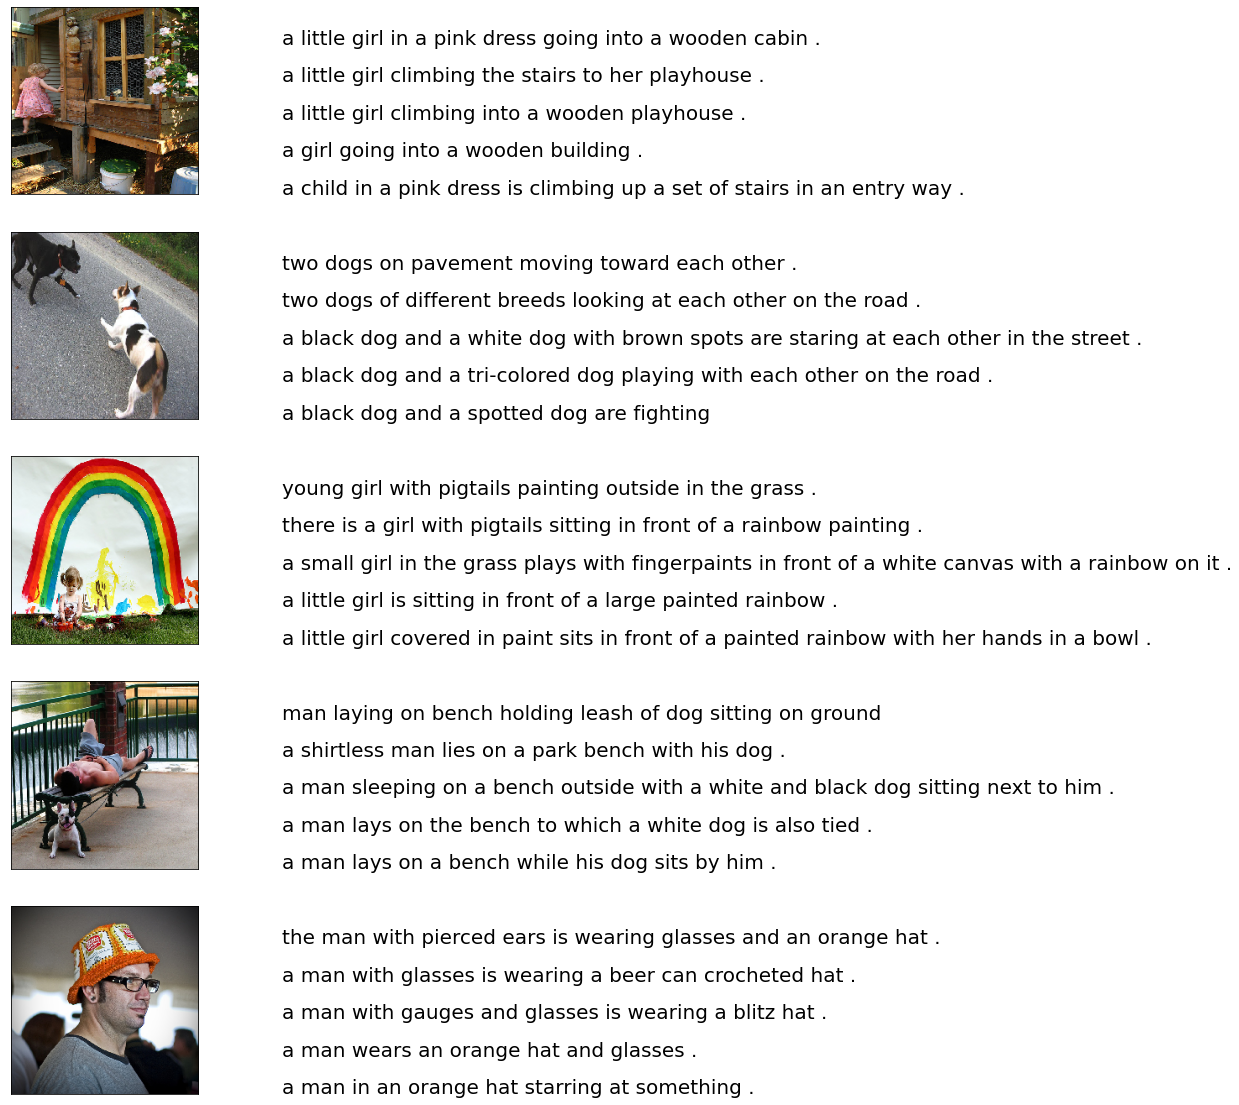

In [4]:
# Defining Parameters for plotting
npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))

# Iterating top 5 images
for jpgfnm in uni_filenames[:npic]:
    filename = images + '/' + jpgfnm
    # Scrapping captions for the image
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    # Plotting using Subplots
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    # Adding counter variable
    count += 1
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    # Printing Captions
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
# Final Plotting    
plt.show()

<font size = 4>The 5 captions for each image share many common words and very similar meaning. Some sentences finish with "." but not all.</font>

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Preparing Text Data</font></h4>
    </strong>
</div>

In [5]:
# Loading Data Function
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
filename = tokens
# load descriptions
doc = load_doc(filename)

<font size = 4>Each photo has a unique identifier. This identifier is used on the photo filename and in the text file of descriptions.</font>

In [6]:
# Loading Descriptions for all images
def load_descriptions(doc):
    mapping = dict()
    
    # process lines
    for line in doc.split('\n'):
        
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
            
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        
        # remove filename from image id
        image_id = image_id.split('.')[0]
        
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
            
        # store description
        mapping[image_id].append(image_desc)
    return mapping

# Parsing descriptions
descriptions = load_descriptions(doc)

In [7]:
# Most Frequent Words
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":ct.keys(),"count":ct.values()})
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(5)

Vocabulary Size: 8918


,word,count
0,a,62989
1,child,1545
2,in,18975
3,pink,735
4,dress,348


<font size = 4> We can see that in 40,000 sentences unique word counts are only 8918 (very less). Most of the words are repeted in all the sentences

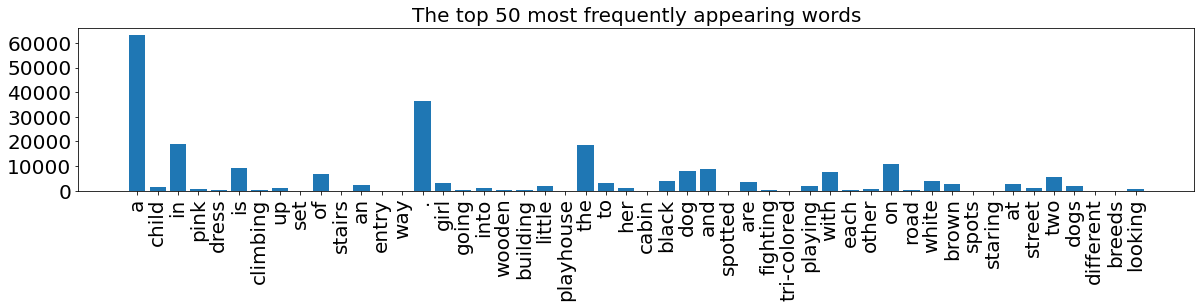

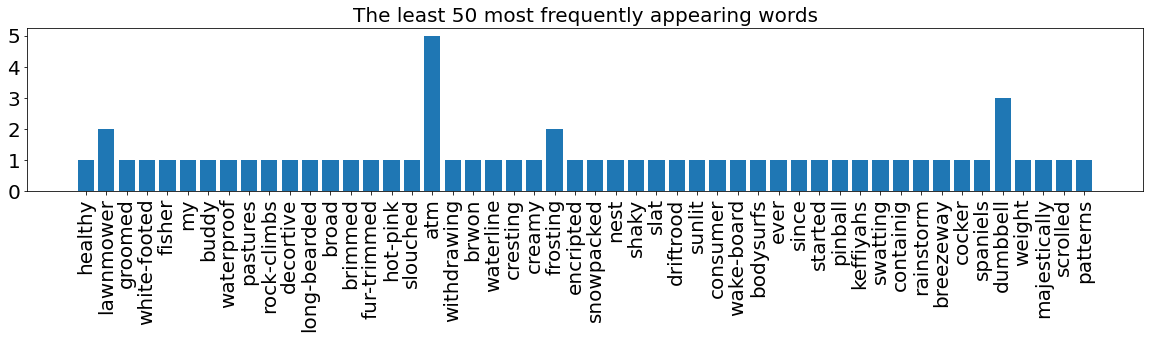

In [8]:
# Most Occuring & Least Occuring Words
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

<font size = 4>
Cleaning the text to reduce the size of the vocabulary of words<br>

<ul>    
 <li>Convert all words to lowercase.</li>
<li>Remove all punctuation.</li>
<li>Remove all words that are one character or less in length (e.g. ‘a’).</li>
<li>Remove all words with numbers in them.</li>
 <ul></font>

In [9]:
# Data Cleaning
def clean_descriptions(descriptions):
    
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)

    # Iterating through descriptions
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            
            # tokenize
            desc = desc.split()
            
            # convert to lower case
            desc = [word.lower() for word in desc]
            
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            
            # store as string
            desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [10]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8763


<font size = 4> After cleaning the data, around 200 uniques words have been removed</font>

In [11]:
# saving descriptions to file in the format of one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

# save descriptions
save_descriptions(descriptions, 'descriptions.txt')

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Preparing Image Data</font></h4>
    </strong>
</div>

<font size = 4>We are using a pre-trained model to interpret the content of the photos. We didn't use this model as broader image caption model inside the main model because it is a large model and running each photo through the network every time will be consuming more time. So, we pre-computed the “photo features” using the pre-trained model and save them to file and we load these features later and feed them into our model as the interpretation of a given photo in the dataset.<br><br><b>This is an optimization method we tries to make training our models faster and consume less memory.</b><br></font>

In [12]:
# extract features from each photo in the directory
def extract_features(directory):
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # summarize
    print(model.summary())
    # extract features from each photo
    features = dict()
    for name in listdir(directory):
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model
        image = preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
        print('>%s' % name)
    return features

# extract features from all images
directory = images
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features.pkl', 'wb'))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

>1225443522_1633e7121f.jpg
>1227655020_b11a1bb112.jpg
>1229756013_94663527d7.jpg
>1231229740_8dcbf80bfb.jpg
>1232148178_4f45cc3284.jpg
>1234293791_6566284bcd.jpg
>1234817607_924893f6e1.jpg
>1235580648_7eebaed9bc.jpg
>1235681222_819231767a.jpg
>1235685934_be89b231fb.jpg
>1236951314_0308dc4138.jpg
>1236964638_1808784a3c.jpg
>1237985362_dbafc59280.jpg
>123889082_d3751e0350.jpg
>123997871_6a9ca987b1.jpg
>1240297429_c36ae0c58f.jpg
>124195430_d14028660f.jpg
>1244140539_da4804d828.jpg
>1244306891_8e78ae1620.jpg
>1244485675_822e6efe60.jpg
>1245022983_fb329886dd.jpg
>1247181182_35cabd76f3.jpg
>1248357227_2b4175fc39.jpg
>1248734482_3038218f3b.jpg
>124881487_36e668145d.jpg
>1248940539_46d33ed487.jpg
>1248953128_24c9f8d924.jpg
>124972799_de706b6d0b.jpg
>1251558317_4ef844b775.jpg
>1252396628_eb81d3905b.jpg
>1252787177_4b08625897.jpg
>125319704_49ead3463c.jpg
>1253264731_e7c689eca5.jpg
>1253275679_e955fb7304.jpg
>1255504166_f2437febcb.jpg
>1258913059_07c613f7ff.jpg
>1259936608_e3f0064f23.jpg
>126081

>1459250022_bf1eddad11.jpg
>1460352062_d64fb633e0.jpg
>1460500597_866fa0c6f3.jpg
>146098876_0d99d7fb98.jpg
>146100443_906d87faa2.jpg
>1461329041_c623b06e5b.jpg
>1461653394_8ab96aae63.jpg
>1461667284_041c8a2475.jpg
>1463638541_c02cfa04dc.jpg
>1463732130_a754441289.jpg
>1463732807_0cdf4f22c7.jpg
>1464120327_d90279ca3a.jpg
>1465666502_de289b3b9c.jpg
>146577645_91b570c0d0.jpg
>146577646_9e64b8c2dc.jpg
>1466307485_5e6743332e.jpg
>1466307489_cb8a74de09.jpg
>1466479163_439db855af.jpg
>1467533293_a2656cc000.jpg
>1468103286_96a6e07029.jpg
>1468389504_c724bdcad0.jpg
>1468429623_f001988691.jpg
>1468962616_5803b4397f.jpg
>1469000260_5d473c8283.jpg
>1469358746_2a879abaf3.jpg
>1470061031_4cb59c12a8.jpg
>1470132731_fa416b7504.jpg
>1470536919_1f3fd6c65a.jpg
>1472053993_bed67a3ba7.jpg
>1472230829_803818a383.jpg
>1472249944_d887c3aeda.jpg
>1472653060_7427d2865a.jpg
>1472882567_33dc14c8b6.jpg
>1473080948_bae2925dc8.jpg
>1473250020_dc829a090f.jpg
>1473618073_7db56a5237.jpg
>1474474514_b3eb492722.jpg
>1475

>1932314876_9cc46fd054.jpg
>1936215201_d03a75cbba.jpg
>1937104503_313d22a2d0.jpg
>1937262236_cbf5bfa101.jpg
>1947351225_288d788983.jpg
>195084264_72fb347b0f.jpg
>1952896009_cee8147c90.jpg
>1956678973_223cb1b847.jpg
>1956944011_c5661d3f22.jpg
>1957371533_62bc720bac.jpg
>195962284_e57178054a.jpg
>195962790_3380aea352.jpg
>1962729184_6996e128e7.jpg
>1965278563_8279e408de.jpg
>1969573381_5ecfae4c80.jpg
>197107117_4b438b1872.jpg
>197142902_f05ff198c2.jpg
>197504190_fd1fc3d4b7.jpg
>1975171469_84e425f61b.jpg
>1975531316_8b00eeaaf7.jpg
>1977827746_4e13d7e19f.jpg
>197924859_f6e39a7dfa.jpg
>1980315248_82dbc34676.jpg
>1980882959_9a161f3469.jpg
>1982852140_56425fa7a2.jpg
>1984936420_3f3102132b.jpg
>1989145280_3b54452188.jpg
>1991806812_065f747689.jpg
>1994416869_4dd769a806.jpg
>199463720_329a802206.jpg
>199809190_e3f6bbe2bc.jpg
>1998255400_0cd086908f.jpg
>1998457059_c9ac9a1e1a.jpg
>1999444757_1b92efb590.jpg
>2000459828_3c9e109106.jpg
>2003663004_5b70920a98.jpg
>2004674713_2883e63c67.jpg
>200771289

>215214751_e913b6ff09.jpg
>2156131463_5b53636cf0.jpg
>2156726763_034ecd2e39.jpg
>2157003092_eaeb977789.jpg
>2157173498_2eea42ee38.jpg
>2158247955_484f0a1f11.jpg
>2158267555_db1d94e468.jpg
>215876547_fa584c5ec3.jpg
>2159447283_fab8c272b0.jpg
>2160266952_a2ab39191b.jpg
>216172386_9ac5356dae.jpg
>2161799386_27aa938421.jpg
>2162469360_ff777edc95.jpg
>2162564553_96de62c7e6.jpg
>2164363131_6930455d45.jpg
>2165459064_5b81ff23eb.jpg
>2165461920_1a4144eb2b.jpg
>2165677531_e1d5e086f7.jpg
>2167644298_100ca79f54.jpg
>2169067981_cc19268f23.jpg
>2169951750_495820a215.jpg
>2170187328_65c2f11891.jpg
>2170222061_e8bce4a32d.jpg
>2171154778_8189169336.jpg
>2171576939_d1e72daab2.jpg
>2171891283_dedd9cf416.jpg
>2172493537_128bc8b187.jpg
>2172526745_649f420569.jpg
>2173061319_1f267765dc.jpg
>2173312932_269f9786fc.jpg
>2173677067_9d0732bcc2.jpg
>2174206711_11cb712a8d.jpg
>217583047_5e93e1e119.jpg
>2176147758_9a8deba576.jpg
>2176364472_31fcd37531.jpg
>2176874361_2b4149010b.jpg
>2176980976_7054c99621.jpg
>2178

>2276120079_4f235470bc.jpg
>2276314067_7ee246f859.jpg
>2276499757_b44dc6f8ce.jpg
>2277081067_d2b4c98bce.jpg
>2277299634_e14bdb7ff7.jpg
>2278110011_ba846e7795.jpg
>2278766574_f71f1704a8.jpg
>2278776373_fe499a93be.jpg
>2279496715_8ef3ee6edb.jpg
>2279945145_8815c59217.jpg
>2279980395_989d48ae72.jpg
>2280354512_c0d035d53f.jpg
>2280525192_81911f2b00.jpg
>2281006675_fde04e93dd.jpg
>2281054343_95d6d3b882.jpg
>2281075738_230892b241.jpg
>2281768510_9cc5728c55.jpg
>2282043629_91b7831352.jpg
>2282260240_55387258de.jpg
>2282522980_45cfa8e0cf.jpg
>2282600972_c22d1e03c7.jpg
>2282895743_f803f1cf01.jpg
>2283966256_70317e1759.jpg
>2284239186_c827f4defa.jpg
>2284894733_b710b9b106.jpg
>2285152690_3fb93f65f1.jpg
>2285570521_05015cbf4b.jpg
>2285741931_07159a21f2.jpg
>2286032269_8ba929709c.jpg
>2286235203_af3cd8f243.jpg
>2286236765_2a63eeb550.jpg
>2286239223_d84ffc4e4a.jpg
>2286270205_16038dec5a.jpg
>2286823363_7d554ea740.jpg
>2287023569_fd7a9c60b8.jpg
>2287887341_663bfa15af.jpg
>2288099178_41091aa00c.jpg
>

>2394919002_ed7527ff93.jpg
>2394922193_310166d6af.jpg
>2395967330_7e6ea404f6.jpg
>2396025708_e4a72e2558.jpg
>2396100671_3a9d67f03d.jpg
>2396669903_5217a83641.jpg
>2396691909_6b8c2f7c44.jpg
>2396746868_0727e06983.jpg
>239807547_4923efc821.jpg
>2398605966_1d0c9e6a20.jpg
>2399114095_c3196ff456.jpg
>2399219552_bbba0a9a59.jpg
>2399551242_c62a46dd5f.jpg
>2400958566_4e09424046.jpg
>2402462857_7684848704.jpg
>2402744031_11f9f2f2b8.jpg
>2402793046_3385554e81.jpg
>2403078014_4b1d6f8bde.jpg
>2403376030_903521c371.jpg
>2403544744_cba152f5c1.jpg
>2404488732_ca1bbdacc2.jpg
>2404520067_87798dbaee.jpg
>2404692474_37da774368.jpg
>2405599120_ec5f32af6f.jpg
>240583223_e26e17ee96.jpg
>2405978603_6221b0c2e7.jpg
>2406591500_403f145905.jpg
>240696675_7d05193aa0.jpg
>2407091303_931c918490.jpg
>2407470303_6fd5e3600d.jpg
>2409312675_7755a7b816.jpg
>2409597310_958f5d8aff.jpg
>2410040397_1a161a1146.jpg
>2410153942_ba4a136358.jpg
>241031254_0c6f30e3d1.jpg
>241031670_e60f59b8e4.jpg
>2410320522_d967f0b75c.jpg
>24103

>2475162978_2c51048dca.jpg
>2475300106_b8563111ba.jpg
>247617035_9f2e821534.jpg
>247617754_4b1137de8c.jpg
>247618600_239eeac405.jpg
>247619370_a01fb21dd3.jpg
>2476214153_99a3998509.jpg
>247637795_fdf26a03cf.jpg
>247652942_29ede19352.jpg
>247691240_3881777ab8.jpg
>247704641_d883902277.jpg
>247706586_7e25c7adf8.jpg
>2477121456_1ac5c6d3e4.jpg
>2477623312_58e8e8c8af.jpg
>247778426_fd59734130.jpg
>2478929971_9eb6c074b6.jpg
>2479162876_a5ce3306af.jpg
>2479180530_7ebba2d8bf.jpg
>2479553749_f7ac031940.jpg
>2479652566_8f9fac8af5.jpg
>2480021389_dda9fb2818.jpg
>2480327661_fb69829f57.jpg
>2480664591_e6d22ed61c.jpg
>2480668859_6f9b46be6a.jpg
>2480820830_bdec1f5b76.jpg
>2480832276_fa55480ecb.jpg
>2480850054_de3433b54a.jpg
>2481003841_06086eafc2.jpg
>2481367956_8577d2fa98.jpg
>2481490320_7978c76271.jpg
>2481598514_05a65d1f72.jpg
>248174959_2522871152.jpg
>2482629385_f370b290d1.jpg
>2483792149_a9b4ffecec.jpg
>2483993772_f64e9e4724.jpg
>2483993827_243894a4f9.jpg
>2484190118_e89363c465.jpg
>2485467050_

>2579460386_94c489028d.jpg
>2579572274_826598b14a.jpg
>2579899436_5086a33c7a.jpg
>2580215443_4e64afe3d5.jpg
>2581066814_179d28f306.jpg
>2582390123_71120edb0c.jpg
>2583001715_1ce6f58942.jpg
>2584020755_14e2b3e8fc.jpg
>2584412512_6767593f24.jpg
>2584487952_f70e5aa9bf.jpg
>258476074_f28f4a1ae6.jpg
>2584957647_4f9235c150.jpg
>2585141045_b496a7b7c4.jpg
>2586028627_ddd054d8cc.jpg
>2586532797_dcf22a5021.jpg
>2586911841_41b7a48c91.jpg
>2587017287_888c811b5a.jpg
>2587106431_1cc0e719c6.jpg
>2587696611_db0378710f.jpg
>2587818583_4aa8e7b174.jpg
>2587846523_b177c9a3e3.jpg
>2588456052_8842b47005.jpg
>2588625139_fdf6610218.jpg
>2588927489_f4da2f11ec.jpg
>2589156742_c46bc82137.jpg
>2589241160_3832440850.jpg
>2589308405_e208b5e745.jpg
>2590207488_ddd89037ba.jpg
>2591110592_ef5f54f91c.jpg
>2591455200_2319651f2f.jpg
>2591486448_48d5438343.jpg
>2591603141_33d6397e0a.jpg
>2592019072_a6c0090da4.jpg
>2592711202_55f8c64495.jpg
>259314892_a42b8af664.jpg
>2593406865_ab98490c1f.jpg
>2593695271_4d9cc9bd6f.jpg
>25

>2682194299_92005b26c6.jpg
>2682382530_f9f8fd1e89.jpg
>268365231_a0acecdc45.jpg
>2683963310_20dcd5e566.jpg
>2683985894_167d267dcb.jpg
>2684322797_85406f571d.jpg
>2684323357_c7a6d05d05.jpg
>2684489465_32ba1d0344.jpg
>2685139184_4ff45e0f76.jpg
>2685752892_9d5cd7f274.jpg
>2685788323_ceab14534a.jpg
>2686432878_0697dbc048.jpg
>268654674_d29e00b3d0.jpg
>268704620_8a8cef4cb3.jpg
>2687229880_97cfd8148e.jpg
>2687328779_b4356dab16.jpg
>2687529141_edee32649e.jpg
>2687539673_d54a8dc613.jpg
>2687672606_275169c35d.jpg
>2688102742_885e578a3f.jpg
>2688902319_52ceaf4a2a.jpg
>2689001252_e0016c89f0.jpg
>2689163361_4939875be5.jpg
>2689358407_9932f1b20c.jpg
>2689491604_d8760f57b4.jpg
>2690538407_7ca157be85.jpg
>2690702549_cf81da8cf6.jpg
>2691966747_cfa154982b.jpg
>2692635048_16c279ff9e.jpg
>2693425189_47740c22ed.jpg
>2693539377_5442430f81.jpg
>269361490_a22ae818bf.jpg
>2694178830_116be6a6a9.jpg
>2694426634_118566f7ab.jpg
>2694890967_7c7a89de16.jpg
>2695001634_127fe2f0d7.jpg
>2695085448_a11833df95.jpg
>2695

>2786299623_a3c48bd318.jpg
>2787276494_82703f570a.jpg
>2787868417_810985234d.jpg
>2788628994_61123c03d2.jpg
>2788652511_4f10060e07.jpg
>2788945468_74a9618cfa.jpg
>2789238858_14261dd25a.jpg
>2789350645_96a2535b4d.jpg
>2789648482_1df61f224a.jpg
>2789688929_9424fceed1.jpg
>2789937754_5d1fa62e95.jpg
>2790909995_8b7a03d9d1.jpg
>2792195540_af5fb95caa.jpg
>2792212974_23b1ef05fa.jpg
>279230262_e541f9b670.jpg
>2792409624_2731b1072c.jpg
>2795287622_da187a3e86.jpg
>2795352290_9209b214f3.jpg
>279550225_d64d56158a.jpg
>2795866891_7559fd8422.jpg
>2796801478_8ebd7e550b.jpg
>2797149878_bb8e27ecf9.jpg
>2797185895_4d9e1e9508.jpg
>2797188545_aeb26c54c0.jpg
>279728508_6bd7281f3c.jpg
>2797438951_88a3ed7541.jpg
>2797511323_bf20acab45.jpg
>2798651021_2566f2a47e.jpg
>2798880731_4f51634374.jpg
>279901198_e7a88c855a.jpg
>2799871904_3b3125518a.jpg
>2800004913_c8394ba332.jpg
>2800758232_d7fa598065.jpg
>2800934095_b84a5009dd.jpg
>2800990525_a1f8427272.jpg
>2801146217_03a0b59ccb.jpg
>2801851082_8c3c480c0f.jpg
>2802

>2883324329_24361e2d49.jpg
>2883907436_82bf4a36b8.jpg
>2883950737_3b67d24af4.jpg
>2884092603_786b53a74b.jpg
>2884252132_5d8e776893.jpg
>2884301336_dc8e974431.jpg
>2884400562_e0851014fc.jpg
>2884420269_225d27f242.jpg
>2884651479_12e400ee58.jpg
>288508162_1727873924.jpg
>2885111681_dc328ecfff.jpg
>2885382946_f541ea5722.jpg
>2885387575_9127ea10f1.jpg
>2885891981_6b02620ae9.jpg
>2885912662_a3a2dfde45.jpg
>2886411666_72d8b12ce4.jpg
>2886533440_dfa832f2fa.jpg
>2886837407_a4510ab1ef.jpg
>2887103049_a867e74358.jpg
>2887171449_f54a2b9f39.jpg
>2887614578_ed7ba21775.jpg
>2887744223_029f2fd5fe.jpg
>2887750774_920eb171aa.jpg
>2887798667_ce761d45e8.jpg
>2888386138_578d21033a.jpg
>2888408966_376c195b3f.jpg
>2888658480_e922a3dec2.jpg
>2888702775_0939a6680e.jpg
>2888732432_7e907a3df1.jpg
>288880576_818b6ecfef.jpg
>2890057168_c712f932e0.jpg
>2890075175_4bd32b201a.jpg
>2890113532_ab2003d74e.jpg
>2890731828_8a7032503a.jpg
>2891162278_fbf96be4f4.jpg
>2891185857_54942809cf.jpg
>2891240104_6755281868.jpg
>28

>297169473_d3974e0275.jpg
>297285273_688e44c014.jpg
>2972864304_481aeffe50.jpg
>2972929655_04233b5489.jpg
>2973269132_252bfd0160.jpg
>2973272684_4d63cbc241.jpg
>2973638173_0dc21fd443.jpg
>2974501005_346f74e5d8.jpg
>2974587819_742fb7c338.jpg
>2975018306_0e8da316f5.jpg
>2975073156_7543ed326f.jpg
>2975118353_5af5a5df54.jpg
>2975253472_0f0c2dea70.jpg
>2975807155_5a8610c297.jpg
>2976155358_b4dd4407cf.jpg
>2976350388_3984e3193d.jpg
>2976537455_f3988c2d46.jpg
>2976684095_ce7ccfd423.jpg
>2976946039_fb9147908d.jpg
>297724467_e8918a6f90.jpg
>2977246776_b14be8290d.jpg
>2977379863_2e8d7a104e.jpg
>2978024878_a45b282bf4.jpg
>2978236380_fb24c43f1e.jpg
>2978271431_f6a7f19825.jpg
>2978394277_4572967b97.jpg
>2978409165_acc4f29a40.jpg
>2978735290_7464b12270.jpg
>2978810122_183e60ff2d.jpg
>2979914158_5906470b8f.jpg
>2980118787_2099de53ec.jpg
>2980348138_91cc6f6d0f.jpg
>2980445969_a86f4e6a0e.jpg
>2981372647_2061278c60.jpg
>2981702521_2459f2c1c4.jpg
>2982881046_45765ced2c.jpg
>2982928615_06db40f4cd.jpg
>298

>3054200086_657d4398e8.jpg
>3054989420_3e755ca352.jpg
>3054997030_797096dd12.jpg
>3055716848_b253324afc.jpg
>3056530884_27766059bc.jpg
>3056569684_c264c88d00.jpg
>3057497487_57ecc60ff1.jpg
>305749904_54a612fd1a.jpg
>3057618932_3b80ae85de.jpg
>3057770908_3fd97f79f9.jpg
>3057862887_135c61816a.jpg
>3058439373_9276a4702a.jpg
>3058627443_1d57ff0a2c.jpg
>3060519665_4d6b9a51b2.jpg
>3060594966_030658d318.jpg
>3060969260_08f43e4f4f.jpg
>3061481868_d1e00b1f2e.jpg
>3062173277_bfb5ef4c45.jpg
>3062273350_fd66106f21.jpg
>306315650_e064f5c677.jpg
>306318683_5f1f875191.jpg
>3063544435_10516c6937.jpg
>3064097919_e536ab9693.jpg
>3064383768_f6838f57da.jpg
>3064716525_b8418d4946.jpg
>3065468339_4955e90fd3.jpg
>3065560742_f6e266ccd9.jpg
>3066338314_2c3fb731d1.jpg
>3066429707_842e50b8f7.jpg
>3066491113_86569e15be.jpg
>3067500667_0fce8f28d4.jpg
>3067885047_f69d90c35b.jpg
>3067971348_69af5bb309.jpg
>3068407619_5207b26986.jpg
>3068735836_872fba3068.jpg
>3068945309_ff0973e859.jpg
>3068994801_b2bc079e67.jpg
>306

>3133044777_8cc930a4ec.jpg
>313326614_b2adbe59e0.jpg
>3133403457_95dfe11da1.jpg
>3133825703_359a0c414d.jpg
>3134092148_151154139a.jpg
>3134341610_3c55e373a7.jpg
>3134385454_4f1d55333f.jpg
>3134387321_3a253224c1.jpg
>3134387513_ceb75bea0a.jpg
>3134585858_a8c3493ca5.jpg
>3134586018_ae03ba20a0.jpg
>3134644844_493eec6cdc.jpg
>3135504530_0f4130d8f8.jpg
>3135826945_f7c741e5b7.jpg
>3136043366_b3f8607a0e.jpg
>3136404885_f4d8f1d15a.jpg
>3136674757_57406c305c.jpg
>3136688093_568b053bdf.jpg
>3137061312_eb5fdcf3fd.jpg
>3138399980_d6ab8b2272.jpg
>3138433655_ea1d59e5b7.jpg
>3138504165_c7ae396294.jpg
>3138562460_44227a35cf.jpg
>3138746531_f6b816c126.jpg
>3139118874_599b30b116.jpg
>3139160252_75109e9e05.jpg
>3139238055_2817a0c7d8.jpg
>3139389284_f01bd4c236.jpg
>3139393607_f0a54ca46d.jpg
>3139837262_fe5ee7ccd9.jpg
>3139876823_859c7d7c23.jpg
>3139895886_5a6d495b13.jpg
>3141293960_74459f0a24.jpg
>3141440149_00becbbb93.jpg
>3141613533_595723208d.jpg
>3142055158_01b9e4caa4.jpg
>3143155555_32b6d24f34.jpg
>3

>3203707977_cc9448fecb.jpg
>3203742047_6a55065411.jpg
>3203872773_6c30f64be3.jpg
>3203878596_cbb307ce3b.jpg
>3203908917_53e53c03d1.jpg
>3204081508_0e7f408097.jpg
>3204354161_caf89ec784.jpg
>3204525212_d548c7fca7.jpg
>3204686006_88f04547b9.jpg
>3204712107_5a06a81002.jpg
>3204922011_185e48949a.jpg
>3205214191_29b42b9b09.jpg
>3205336477_037d4b6bd9.jpg
>3205754736_32c29b5208.jpg
>3205839744_24504ba179.jpg
>3206058778_7053ee6b52.jpg
>3206919175_e3a11b6874.jpg
>3206999917_e682672cbc.jpg
>3207264553_8cd4dcde53.jpg
>3207343907_995f7ac1d2.jpg
>3207358897_bfa61fa3c6.jpg
>3207654194_43d6bebd68.jpg
>3207676216_48478bce97.jpg
>3207775692_bb897d9afd.jpg
>3208032657_27b9d6c4f3.jpg
>3208074567_ac44aeb3f3.jpg
>3208188198_2b271d2a2e.jpg
>3208553539_2bf6c6d162.jpg
>3208571574_6dc1a461c5.jpg
>3208987435_780ae35ef0.jpg
>3208999896_dab42dc40b.jpg
>3209350613_eb86579ee8.jpg
>3209523192_05a4cef844.jpg
>3209564153_077ed4d246.jpg
>3209620285_edfc479392.jpg
>3209966887_5b744bd050.jpg
>3210359094_ee51285301.jpg
>

>3259992638_0612a40288.jpg
>3259992722_4c5e895734.jpg
>3260088697_af9b6d2393.jpg
>3260191163_6c1551eee8.jpg
>3260214530_7179346407.jpg
>326028454_fb396167e6.jpg
>3260768565_2b725be090.jpg
>3260975858_75d0612a69.jpg
>3261493263_381a4c5cc7.jpg
>3261666285_86fceb762d.jpg
>3262075846_5695021d84.jpg
>3262301835_9f1a49b80a.jpg
>3262386960_14f5d857db.jpg
>3262475923_f1f77fcd9f.jpg
>3262647146_a53770a21d.jpg
>3262760716_1e9734f5ba.jpg
>3262793378_773b21ec19.jpg
>3262849619_0bc4f88ef9.jpg
>3263141261_db3a4798b5.jpg
>3263215700_e27f81f8b9.jpg
>326334188_8850b7bfd4.jpg
>3263395801_5e4cee2b9e.jpg
>3263497678_8bb688ca01.jpg
>3263741906_6e4508d1c8.jpg
>3263946591_a1558b77d3.jpg
>3264337159_e1680a35ba.jpg
>3264350290_f50494e835.jpg
>3264397357_72f084cac1.jpg
>3264464625_c711cc40c6.jpg
>326456451_effadbbe49.jpg
>3264650118_be7df266e7.jpg
>3264678536_46601d25f0.jpg
>3264937930_9623496b64.jpg
>3265162450_5b4e3c5f1b.jpg
>3265209567_b3b9c8e0fe.jpg
>3265527323_6431f00692.jpg
>3265578645_4044a7049a.jpg
>326

>3328247381_a9f7fb4898.jpg
>3328397409_092de2bd32.jpg
>3328495660_ed0e3f29cf.jpg
>3328535573_33c3cd5b59.jpg
>3328646934_5cca4cebce.jpg
>3329169877_175cb16845.jpg
>3329254388_27017bab30.jpg
>3329289652_e09b80e2f3.jpg
>3329777647_5e1fd503ac.jpg
>3329793486_afc16663cc.jpg
>3329858093_0ec73f2190.jpg
>3330007895_78303e8a40.jpg
>3330019493_fd36fbc2ea.jpg
>3330102093_1d6e35e78d.jpg
>333031366_a0828c540d.jpg
>3330333217_1a69497a74.jpg
>3330654550_3efe9a71af.jpg
>3330675488_8692476a4a.jpg
>3330680118_4e541889c1.jpg
>3330935489_9cb67ca36b.jpg
>3331009729_d3b14738e6.jpg
>3331102049_bc65cf6198.jpg
>3331190056_09f4ca9fd2.jpg
>3331525712_af1dcc47f2.jpg
>3331797838_b3e33dbe17.jpg
>3331900249_5872e90b25.jpg
>3332136681_9aecf101fd.jpg
>3332202255_a30c522664.jpg
>3332248667_617606714b.jpg
>3332467180_d72f9b067d.jpg
>3333017828_b930b9d41b.jpg
>3333039854_461329aac2.jpg
>3333675897_0043f992d3.jpg
>3333826465_9c84c1b3c6.jpg
>3333921867_6cc7d7c73d.jpg
>3334057289_68ece38a85.jpg
>3334300164_e75e0479ae.jpg
>3

>3385956569_a849218e34.jpg
>3386060324_b98fdfa449.jpg
>3386375153_20c56d0aae.jpg
>3386893620_5f0bb4e794.jpg
>3386953179_84c2d7922f.jpg
>3387542157_81bfd00072.jpg
>3387630781_f421a94d9d.jpg
>3387661249_33e5ba0bc5.jpg
>3388094307_5a83be64a5.jpg
>3388330419_85d72f7cda.jpg
>3388836914_c267cf3a59.jpg
>3389321512_b11f499dab.jpg
>3389448506_7025e7cc12.jpg
>3391209042_d2de8a8978.jpg
>3391924827_53b31542ce.jpg
>3392019836_c7aeebca1c.jpg
>3392293702_ccb0599857.jpg
>3392851587_a638ff25e2.jpg
>3393035454_2d2370ffd4.jpg
>3393152604_27bd1037f2.jpg
>3393343330_b13df4d8ec.jpg
>3393394134_0caac47e1c.jpg
>3393446245_37dd3f3b59.jpg
>339350939_6643bfb270.jpg
>3393926562_66cc01b001.jpg
>3394070357_cb2a3243fc.jpg
>3394586927_eae7732b64.jpg
>3394654132_9a8659605c.jpg
>3394750987_a32ecc477e.jpg
>3395173129_f0ac0a1ed4.jpg
>3396036947_0af6c3aab7.jpg
>3396043950_12783c5147.jpg
>3396153660_f729d9f9b9.jpg
>3396157719_6807d52a81.jpg
>3396251819_1efa69310f.jpg
>3396275223_ee080df8b5.jpg
>339658315_fbb178c252.jpg
>33

>3444982197_0ff15cc50b.jpg
>3445296377_1e5082b44b.jpg
>3445428367_25bafffe75.jpg
>3445544288_68fdb25969.jpg
>3446191973_1db572ed8a.jpg
>3446347599_0ecc49a9d5.jpg
>3446586125_cafa0bfd67.jpg
>3446762868_06e9d9d899.jpg
>3447007090_08d997833a.jpg
>3447155358_5b5b59b15e.jpg
>3447876218_4ccf42d7a0.jpg
>344841963_8b0fa9784c.jpg
>3448490813_f9623e864d.jpg
>3448855727_f16dea7b03.jpg
>3449114979_6cdc3e8da8.jpg
>3449170348_34dac4a380.jpg
>3449718979_e987c64e2d.jpg
>3449846784_278bc1ba92.jpg
>3450776690_38605c667d.jpg
>3450874870_c4dcf58fb3.jpg
>3451085951_e66f7f5d5c.jpg
>3451344589_6787bd06ef.jpg
>3451345621_fe470d4cf8.jpg
>3451523035_b61d79f6a8.jpg
>3451984463_37ac1ff7a8.jpg
>3452127051_fa54a902b3.jpg
>3452341579_0147d2199b.jpg
>3452411712_5b42d2a1b5.jpg
>345284642_77dded0907.jpg
>3452982513_36f2bc81fa.jpg
>3453019315_cfd5c10dae.jpg
>3453259666_9ecaa8bb4b.jpg
>3453284877_8866189055.jpg
>3453313865_1ebff5393c.jpg
>3453544202_3855ab34b6.jpg
>3454149297_01454a2554.jpg
>3454199170_ae26917dcd.jpg
>34

>3506216254_04d119cac7.jpg
>3506468593_7e41a6d9f1.jpg
>3506560025_8d0f4f9ac4.jpg
>3506607642_40037b3fbf.jpg
>3506869953_802f463178.jpg
>3507076266_8b17993fbb.jpg
>3507670136_2e5f94accf.jpg
>3508051251_82422717b3.jpg
>3508522093_51f6d77f45.jpg
>3508637029_89f3bdd3a2.jpg
>3508882611_3947c0dbf5.jpg
>3509575615_653cbf01fc.jpg
>3509611207_7645b1d28d.jpg
>3510218982_318f738b76.jpg
>3510219078_670b6b3157.jpg
>3510695264_ef460fa6cc.jpg
>3511062827_cd87871c67.jpg
>3511890331_6163612bb9.jpg
>3512033659_7e8a0c2ffa.jpg
>3512033861_a357bb58b6.jpg
>3512127856_18a4c7aace.jpg
>3512791890_eb065b460a.jpg
>3513265399_a32e8cfd18.jpg
>3513362553_5fc5779e20.jpg
>3514019869_7de4ece2a5.jpg
>3514179514_cbc3371b92.jpg
>3514184232_b336414040.jpg
>3514188115_f51932ae5d.jpg
>3514194772_43ba471982.jpg
>3514278386_de2343577e.jpg
>3514297698_0512623955.jpg
>3515358125_9e1d796244.jpg
>3515451715_ac5ac04efa.jpg
>3515665835_22e6fb1193.jpg
>3515904775_f8acc5909e.jpg
>3516267455_ca17cc1323.jpg
>3516285214_59823b341e.jpg
>

>3563924606_5914392cd8.jpg
>3564007203_df2b8010f1.jpg
>3564148252_aa4cb36a32.jpg
>3564157681_03a13b7112.jpg
>3564312955_716e86c48b.jpg
>3564385317_1bf5094068.jpg
>3564436847_57825db87d.jpg
>3564543247_05cdbc31cf.jpg
>3564738125_10400f69c0.jpg
>3564742915_5f940b95b4.jpg
>3564907603_14ccc655f1.jpg
>3565021218_d2bc1aa644.jpg
>3565598162_56044bc2f7.jpg
>3565654691_22b97d3994.jpg
>3565655045_8eb00b7423.jpg
>3565749152_7924d15b04.jpg
>3566111626_9a35a7b2c0.jpg
>3566225740_375fc15dde.jpg
>3567061016_62768dcce1.jpg
>3567214106_6ece483f8b.jpg
>3567604049_da9e1be4ba.jpg
>3568065409_1c381aa854.jpg
>3568197730_a071d7595b.jpg
>3568219100_dfbffddccd.jpg
>3568225554_73cdb19576.jpg
>3568505408_4e30def669.jpg
>3568605391_54ec367d88.jpg
>3569126684_a68b29a57f.jpg
>3569284680_44fef444ef.jpg
>356929855_6bbf33d933.jpg
>3569329986_1f468729b2.jpg
>3569406219_f37ebf7b92.jpg
>3569420080_72fbe84751.jpg
>3569667295_6e51db08ef.jpg
>3569755200_cef7ee2233.jpg
>3569979711_6507841268.jpg
>3570800810_978c993133.jpg
>3

>3628059004_5c3529b120.jpg
>3628103548_2708abcda2.jpg
>3628698119_5566769777.jpg
>3628994466_a12065d29b.jpg
>3629492654_619d7b67ee.jpg
>3629664676_36bcefe6b7.jpg
>3630102841_b4c3e00b2c.jpg
>3630332976_fdba22c50b.jpg
>3630641436_8f9ac5b9b2.jpg
>3630991662_990f397f7c.jpg
>3631023049_8a85bab19f.jpg
>3631136463_53ff624b82.jpg
>3631344685_ed0f3e091b.jpg
>3631474374_e40764d153.jpg
>3631671718_d712821757.jpg
>3631810528_7233c0f421.jpg
>3631986552_944ea208fc.jpg
>3632047678_f202609e50.jpg
>3632197966_0c5061025f.jpg
>3632225464_612d7b4c0f.jpg
>3632258003_6a0a69bf3a.jpg
>3632572264_577703b384.jpg
>3632842482_482f29e712.jpg
>3633396324_c4b24b1f51.jpg
>3634032601_2236676cdd.jpg
>3634281981_d9cf1d1a33.jpg
>3634400263_c6fcaa48e1.jpg
>3634785801_4b23184a06.jpg
>3634828052_3b6aeda7d6.jpg
>3635177305_bfbe1fc348.jpg
>3635194562_4c1dfa120a.jpg
>3635577874_48ebaac734.jpg
>3635911776_dbc2763f2c.jpg
>3635991166_f95304af0a.jpg
>3636055584_65a60426f8.jpg
>3636126441_5617c89aaa.jpg
>363617160_6cb0c723be.jpg
>3

>3693961165_9d6c333d5b.jpg
>3694064560_467683205b.jpg
>3694071771_ce760db4c7.jpg
>3694093650_547259731e.jpg
>3694219419_a7a83d4886.jpg
>3694555931_7807db2fb4.jpg
>3694991841_141804da1f.jpg
>3695064885_a6922f06b2.jpg
>3695517194_2a6b604cb2.jpg
>3695949492_27ca3892fd.jpg
>3696246123_99d4d10140.jpg
>3696698390_989f1488e7.jpg
>3697003897_d8ac13be9a.jpg
>3697153626_90fb177731.jpg
>3697359692_8a5cdbe4fe.jpg
>3697378565_7060d9281a.jpg
>3697379772_40d831392b.jpg
>3697456750_460aea7252.jpg
>3697675767_97796334e4.jpg
>369802520_9825f2cd84.jpg
>3698607223_22fe09763a.jpg
>3698944019_825ef54f2f.jpg
>3699318394_6193f2c8e0.jpg
>3699522388_2333f01f40.jpg
>3699763582_f28c5130dd.jpg
>3700004668_99c3e3f55b.jpg
>3700322513_50f0d45bfa.jpg
>3700346840_bb80d622f7.jpg
>3700554247_9824ae6f3a.jpg
>3701226275_952547ba0f.jpg
>3701249979_8bc757e171.jpg
>3701291852_373ea46bb6.jpg
>3701509233_a2275a4e57.jpg
>3701544312_b2e4e9813d.jpg
>3701878677_8f2c26227b.jpg
>3702038926_966fdaa311.jpg
>3702436188_2c26192fd0.jpg
>3

>417577408_eb571658c1.jpg
>417966898_a04f9b5349.jpg
>418357172_bdddf71d32.jpg
>418616992_22090c6195.jpg
>418667611_b9995000f4.jpg
>418796494_bdb441de42.jpg
>419116771_642800891d.jpg
>41999070_838089137e.jpg
>420355149_f2076770df.jpg
>421153376_d1d325568f.jpg
>421316045_ae7a1eb4bc.jpg
>421322723_3470543368.jpg
>421706022_1ddb6a7a78.jpg
>421730441_6b2267fd31.jpg
>421808539_57abee6d55.jpg
>421932359_edbf181f44.jpg
>422756764_e7eaac76bf.jpg
>422763475_0bc814dac6.jpg
>423066487_07757b2b49.jpg
>424307754_1e2f44d265.jpg
>424379231_23f1ade134.jpg
>424416723_19c56cb365.jpg
>424506167_01f365726b.jpg
>424779662_568f9606d0.jpg
>424869823_7aec015d87.jpg
>425088533_a460dc4617.jpg
>425518464_a18b87c563.jpg
>425706089_f138118e12.jpg
>426065353_e9a604a01f.jpg
>426191845_1e979e9345.jpg
>42637986_135a9786a6.jpg
>42637987_866635edf6.jpg
>426805536_d1d5e68c17.jpg
>426920445_d07d1fd0f7.jpg
>427082246_5bf1c3676f.jpg
>427167162_2c99779444.jpg
>427557693_1108566fd2.jpg
>427683329_95d510a087.jpg
>427936315_0b8f

>501320769_31eea7b7ea.jpg
>501520507_c86f805ab8.jpg
>501650847_b0beba926c.jpg
>501684722_0f20c4e704.jpg
>501699433_f8df386cf9.jpg
>502115726_927dd684d3.jpg
>502671104_b2114246c7.jpg
>502783522_3656f27014.jpg
>502884177_25939ac000.jpg
>503090187_8758ab5680.jpg
>503717911_fc43cb3cf9.jpg
>503794526_603a7954d3.jpg
>504385521_6e668691a3.jpg
>504765160_b4b083b293.jpg
>504904434_889f426c6e.jpg
>505062117_a70b4e10ab.jpg
>505929313_7668f021ab.jpg
>505944126_f9a6ab8944.jpg
>505955292_026f1489f2.jpg
>506343925_b30a235de6.jpg
>506367606_7cca2bba9b.jpg
>506412121_67ecc7ec05.jpg
>506478284_7cf8bdbe36.jpg
>506738508_327efdf9c3.jpg
>506808265_fe84ada926.jpg
>506882688_b37d549593.jpg
>507758961_e63ca126cc.jpg
>508261758_78fb8ae067.jpg
>508432819_3d055f395d.jpg
>508929192_670910fdd2.jpg
>508958120_afe274f726.jpg
>509123893_07b8ea82a9.jpg
>509200598_171a1ab6c8.jpg
>509241560_00e5b20562.jpg
>509778093_21236bb64d.jpg
>510197538_0a11b94460.jpg
>510510783_b2cf5d57bb.jpg
>510531976_90bbee22a2.jpg
>510791586_3

>694496803_f2a05869cf.jpg
>696663662_232edd58af.jpg
>69710411_2cf537f61f.jpg
>69710415_5c2bfb1058.jpg
>697490420_67d8d2a859.jpg
>697582336_601462e052.jpg
>697778778_b52090709d.jpg
>698107542_3aa0ba78b4.jpg
>700884207_d3ec546494.jpg
>701816897_221bbe761a.jpg
>707941195_4386109029.jpg
>707972553_36816e53a2.jpg
>708860480_1a956ae0f7.jpg
>708945669_08e7ffb9a7.jpg
>709373049_15b8b6457a.jpg
>70995350_75d0698839.jpg
>710878348_323082babd.jpg
>716597900_b72c58362c.jpg
>717673249_ac998cfbe6.jpg
>719837187_3e7bf1d472.jpg
>720208977_f44c2bba5b.jpg
>72218201_e0e9c7d65b.jpg
>724702877_f2a938766b.jpg
>72964268_d532bb8ec7.jpg
>732468337_a37075225e.jpg
>733172023_5810350af6.jpg
>733752482_ee01a419e5.jpg
>733964952_69f011a6c4.jpg
>733965014_1a0b2b5ee9.jpg
>735787579_617b047319.jpg
>742073622_1206be8f7f.jpg
>743571049_68080e8751.jpg
>745563422_f4fa7d9157.jpg
>745880539_cd3f948837.jpg
>745966757_6d16dfad8f.jpg
>746787916_ceb103069f.jpg
>747242766_afdc9cb2ba.jpg
>747921928_48eb02aab2.jpg
>749840385_e004bf

<font size = 4>To understand what is happening inside we can visualize the VGG16 features</font>

In [13]:
# Downloading VGG Weights and loading them
!wget 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5' --no-check-certificat

modelvgg = VGG16(include_top=True)
## load the locally saved weights 
# modelvgg.load_weights("./vgg16_weights_tf_dim_ordering_tf_kernels.h5")
modelvgg.summary()

'wget' is not recognized as an internal or external command,
operable program or batch file.


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

<font size = 4>VGG16 is developed to classify images into 1,000 different classes. As I am not using VGG16 for the sake of the classification but I just need it for extracting features, I will remove the last layer from the network.</font>

In [14]:
# Popping the output layer
modelvgg_new = Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-2].output)
## show the deep learning model
modelvgg_new.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

<font size = 4>Output Layer is Removed from the model architecture</font>

In [15]:
# Extracting features using VGG
import time
jpgs = os.listdir(images)
images_dict = OrderedDict()
npix = 224
target_size = (npix,npix,3)
data = np.zeros((len(jpgs),npix,npix,3))
start = time.time()
for i,name in enumerate(jpgs):
    # load an image from file
    filename = images + '/' + name
    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)
    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images_dict[name] = y_pred.flatten()
end = time.time()
print("Time Taken",end-start)

1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 102ms/step


1/1 [==============================] - 0s 102ms/step


1/1 [==============================] - 0s 103ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 102ms/step


1/1 [==============================] - 0s 103ms/step


1/1 [==============================] - 0s 102ms/step


1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 102ms/step


1/1 [==============================] - 0s 102ms/step


1/1 [==============================] - 0s 103ms/step


1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 124ms/step


1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 129ms/step


1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 106ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 206ms/step


1/1 [==============================] - 0s 202ms/step


1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 167ms/step


1/1 [==============================] - 0s 123ms/step


1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 167ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 127ms/step


1/1 [==============================] - 0s 125ms/step
Time Taken 4257.978018045425


<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Model Building</font></h4>
    </strong>
</div>

In [16]:
# Loading Train Data
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# Load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)


In [17]:
# Function for cleaning descriptions
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions
 
# Function for loading photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

In [18]:
# Applying all functions
filename = train_text

# loading train dataset
train = load_set(filename)
print('Dataset: %d' % len(train))

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

# photo features
train_features = load_photo_features("../Code/flickr8k1/Flickr8k_features/VGG16_Features.pkl", train)
print('Photos: train=%d' % len(train_features))

Dataset: 6000
Descriptions: train=6000
Photos: train=6000


In [19]:
# Applying all functions
filename = test_text

# loading train dataset
test = load_set(filename)
print('Dataset: %d' % len(test))

# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

# photo features
test_features = load_photo_features("../Code/flickr8k1/Flickr8k_features/VGG16_Features.pkl", test)
print('Photos: test=%d' % len(test_features))

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


<font size = 4> This code snippet loads the 6,000 photo identifiers in the training dataset.and these identifiers are then used to filter and load the cleaned description text and the pre-computed photo features.</font>
<br><br>
<font size = 4>The description text will need to be encoded to numbers before it can be presented to the model as in input or compared to the model’s predictions.</font>

In [20]:
# Function to convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# Fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# Initializing tokenizer and 
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 7579


<font size = 4>This function will convert each description into words. The model will be provided one word and the photo and generate the next word. Then the first two words of the description will be provided to the model as input with the image to generate the next word. This is how the model will be trained after this.

<font size = 4>For example, the input sequence “little girl running in field” would be split into 6 input-output pairs to train the model:</font><br><br>
<img src = "https://res.cloudinary.com/qna/image/upload/v1646666088/Screenshot_2022-03-07_204433_ilx7lk.png">

Source : https://machinelearningmastery.com/

<font size = 4>The below function given the tokenizer, a maximum sequence length, and the dictionary of all descriptions and photos, will transform the data into input-output pairs of data for training the model. <br>
    
<font size = 4>There are two input arrays to the model: one for photo features and one for the encoded text. There is one output for the model which is the encoded next word in the text sequence.<br>

<font size = 4>The input text is encoded as integers, which will be fed to a word embedding layer. The photo features will be fed directly to another part of the model. The model will output a prediction, which will be a probability distribution over all words in the vocabulary.

<font size = 4>The output data will therefore be a one-hot encoded version of each word, representing an idealized probability distribution with 0 values at all word positions except the actual word position, which has a value of 1.

In [21]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

<font size = 4>We calculated the maximum number of words in the longest description.</font>

In [22]:
# This function will calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)
max_length = max_length(train_descriptions)

<font size = 4>We tried to load all text, photo features at a stretch and we face memory error. So we created data generator function, It is the data generator by batches and will take the loaded textual descriptions, photo features, tokenizer and max length. 

In [23]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            yield [in_img, in_seq], out_word

### Model is of three parts:
<font size = 4>
Photo Feature Extractor. 16-layer VGG model pre-trained on the ImageNet dataset. We have pre-processed the photos with the VGG model (without the output layer) and will use the extracted features predicted by this model as input.<br><br>

Sequence Processor. This is a word embedding layer for handling the text input, followed by a Long Short-Term Memory (LSTM) recurrent neural network layer.
<br><br>
Decoder (for lack of a better name). Both the feature extractor and sequence processor output a fixed-length vector. These are merged together and processed by a Dense layer to make a final prediction.</font>

In [24]:
# Function for training model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = concatenate([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

<font size = 4>
    The Photo Feature Extractor model expects input photo features to be a vector of 4,096 elements. These are processed by a Dense layer to produce a 256 element representation of the photo.<br><br>

The Sequence Processor model expects input sequences with a pre-defined length (34 words) which are fed into an Embedding layer that uses a mask to ignore padded values. This is followed by an LSTM layer with 256 memory units.<br><br>

Both the input models produce a 256 element vector. Further, both input models use regularization in the form of 50% dropout. This is to reduce overfitting the training dataset, as this model configuration learns very fast.<br><br>

The Decoder model merges the vectors from both input models using an addition operation. This is then fed to a Dense 256 neuron layer and then to a final output Dense layer that makes a softmax prediction over the entire output vocabulary for the next word in the sequence.<br><font>

<img src = "./model.png">

In [25]:
# define the model
model = define_model(vocab_size, max_length)
# train the model, run epochs manually and save after each epoch
epochs = 1
steps = len(train_descriptions)
for i in range(epochs):
    # create the data generator
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
    # fit for one epoch
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps/128, verbose=1)
    # save model
    model.save('model_' + str(i) + '.h5')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 256)      1940224     ['input_4[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_3[0][0]']                
                                                                                            

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Model Evaluation</font></h4>
    </strong>
</div>

<font size = 4>
Evaluating Test images involves passing in the start description token ‘startseq‘, generating one word, then calling the model recursively with generated words as input until the end of sequence token is reached ‘endseq‘ or the maximum description length is reached.<br><br>

The function below named generate_desc() implements this behavior and generates a textual description given a trained model, and a given prepared photo as input. It calls the function word_for_id() in order to map an integer prediction back to a word.</font>

In [26]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

<font size = 4>The function below named evaluate_model() will evaluate a trained model against a given dataset of photo descriptions and photo features. The actual and predicted descriptions are collected and evaluated collectively using the corpus BLEU score that summarizes how close the generated text is to the expected text.</font>

In [27]:
# evaluating the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

<font size = 4> BLEU scores are used in text translation for evaluating translated text against one or more reference translations.

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Hyper Parameter Tuning</font></h4>
    </strong>
</div>

In [28]:
def evaluate_bleu(path):
# loading test images
    filename = test_text
    test = load_set(filename)
    # load the model
    filename = path
    model = load_model(filename)
    # evaluate model
    evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

In [29]:
# With 200 times reinitialization of data generator and 1 epoch and 60 steps per epoch
evaluate_bleu("models_200_60_6000/content/models_200_60_6000/model_190_200_60_6000.h5")

BLEU-1: 0.450682
BLEU-2: 0.199440
BLEU-3: 0.116503
BLEU-4: 0.043059


In [30]:
# With 20 times reinitialization of data generator and 5 epoch and 100 steps per epoch
evaluate_bleu("models_20_5_100/models_20_5_100/model_19_20_5_100.h5")

BLEU-1: 0.461959
BLEU-2: 0.222305
BLEU-3: 0.141835
BLEU-4: 0.057075


In [31]:
# With 30 times reinitialization of data generator and 1 epoch and 1 steps per epoch - Stochastic Gradient Descent
evaluate_bleu("models_30_1_6000/models_30_1_6000/model_29_30_1_6000.h5")

BLEU-1: 0.506571
BLEU-2: 0.263052
BLEU-3: 0.182630
BLEU-4: 0.083303


<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Generating Captions</font></h4>
    </strong>
</div>

In [32]:
# Extract features from each photo in the directory
def extract_features(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

In [38]:
# Loading Random Images
path_1 = "./img1.jpg"
img_1 = urllib.request.urlretrieve("https://st3.depositphotos.com/3825437/12731/i/950/depositphotos_127311372-stock-photo-two-children-playing-on-beach.jpg", path_1) 
path_2 = "./img2.jpg"
img_2 = urllib.request.urlretrieve("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYWFRgWFhYZGRgYGRwYGhocHBoYGhwYGhoZGRoaGhwcIS4lHB4rIRgYJjgmKzAxNTU1GiQ7QDs0Py40NTEBDAwMEA8QGhISHzQhISE0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NP/AABEIALcBEwMBIgACEQEDEQH/xAAcAAACAwEBAQEAAAAAAAAAAAAAAgEDBAUHBgj/xAA+EAABAwIEAgcGBgIBAgcAAAABAAIRAyEEEjFBUWEFEyJxgZGhBjJCscHwFFJi0eHxB4KScrIVI0Nzg5Oi/8QAGAEBAQEBAQAAAAAAAAAAAAAAAAECAwT/xAAhEQEBAQADAAICAwEAAAAAAAAAARECEiEDMUFRInGBMv/aAAwDAQACEQMRAD8A9MNJQaRVzXg7KcwWtYxnDCmAK0ASjKmrigoMq4MU5U0xnlSQr8qCyNk0xQAjKr2s5IDE0xW1qVzVcWqC1NMI1g3TZQmIUQmogBEKS1SjRQEFqYohBU9iJIVjmoiUZVh6tCr6tO1qBg1BAUICNBCmFKBIUplCMgFSCgIKCZQChBRowKJUBCBpQllCgzusFmLitcKA1XUxVSdKulSGBWZBoppIoBUkq3qgoNE7JphMynrAeKbqSlbSKKYRCUp8hQWEIElQ0p3sUQgkOCbOAlDeSYU54IDPKlxjRQKRTCioeozcUSOCnq0CmgXwSuCuyBTkAQxTKM6sNIcVGUKphAVEpi1QWIosiUBqIVENKkhNlSlGQgqQEI0gKUSplGRCEZlBKNJQkQiazdaU7ah4K11MFUtokHWymwyrDUtYJmv5FZ6jDNlbRe4GCir2XTZENdKaVnVKGnipDFOZTKoV1PghtPmnaErjzQI9o3nvUtYNilJlQ2B/aIubZSqyQqn1I0RWooDVRSfKg1UNXkFLlKp69S2uriakmNUwepz9yUPjZQNmR4KS5GZFEclBAUFyguREgckQF89jfbTA03ZH125gSCGhz4ImZLRbRdfCYtlVoex4e06EGQg1EhLKhCCZSlSoIWoyIQiFEIJSlShAmYITwhVAHqVVmTBy4uhiEQozFSHrQkNKmSlzKZU1cMHFMHFVFAKqLcyWoJGqQEqQ5AAGOKDSBU51EoiMhG6qNP7CulNmV2nipjCoL1dmUSmmMpngoeCFqhSVeyYz03laASoDQmlS1ZEF6jrEyCpoqdK5/S/SPVsLRDnuaSGkgDJYOcSbACfXQrqrhe0nR9aq1oo5JEznc5rRMQYDTm03jyJBnLletxrhJ2m/TwLp+i5leqWghofIIsBJEgcbuAnmvp/8a+1poVRReR1bzrMZHH4hNoO/muR7XUajGRUd2nPJLZ3FtN91850VRc+rTY1pcXPa3KMxJkiYDb6TpdT47bx1v5OMlyP1UH81IeqMLQDWNbezQNSdud1cGBdPHIxKJQWqAEBKjMplCAlAQiVWRCEShBnARCA3mfRMG8z6LGVrwAIATBvP5Iy80yniAmCgg8Upnj6JlNixCpL3clHWnkmU2NAUrL1x5KeuKdamxphELN17uSXr3J1psa4UrKK5R17k601pRCz9eeSDXPJXKa0oWbrzyR15TKa1QiFm64o688kymxphQVn688kGueSZTY0ALPj8Yyix1R5hjdT3kAepCBXdyXkvtn7WVMSyo1oa3DtJaw6vq2c1ruDWEyQNSG+b1vhNuOD7a9I0cTVdUYCc5NyC3KAbAA3zakzpmHh9J/iv2cw1TJimvf11B7g9s9klwORwESBlLhF5g9y82FSWA7l7j3zl+sr7f/EeOLMZUpgjLVoyf+pjgW+hcpHb5J/HXtwUrJ+IdyUfiTyWsebWuVCynEO5eSDiHck6psalErL+Idy8lBru5eSuU7NaJWPr3fYUde7l5JlO0bJQsfXu+whXKz2WhycFVh48uCkP81Gl0qA5JPeoPf8A2oLC5ISpB5/JI6OP34IByrNv5t9VIg35cfuyV7GmDtrr9wqJ+v3qoUta3l5qHRw+qCC07JS13IeJTGo0a/uSq8zdZPDQoh2NPEHuVsFUse0xYg8z/KfOPvh3oHCPD78lHWN5ffFR1s2GyKkBMQq3VCOA73RfhMJetd+X6/RE2LR3fJNl5LNUe82BjnB+ZkJR1vFv/E/SFU1qyog/YWZrnnUjxaQmDX7oaue4NBJIAAJJOgAuSeS8E9rQGOZQbbq2jOB+YMbfwaG+F9F7B7S4VzsO/K4jK5r3AfGxjmvew30cAQvBumq+ao86EudO1zINu8me8rFej4fJazEQ1o/TP/Ik/UL6n/Gj46Qp82PHmx0DzAXzOMbDssRlDW+QAXQ9kukWUMQKrxLWh3HUQ4RANzly/wC3BSfbpz842P0N4pc3NcH2a6doYxjnU5aWOyvYTJG7XWsQ4SQRz4LrupMOv34Lo8Xq+eZS5uRVbQ0bkJs3P1QE8j5QmlVudwdCwP6SiqynDjnBIcYDDGzST2j3SqY6WZQ5+USSABqXGAO8nRY3YpwJz0XhoMTDH5r6w10gReXQvmvaHAOL8tWq8seTlbUyhjfiAAaQDfK0Ez33UtyNTjrvVfaWgCRnJjg2R4HdC8wq9PhpLeza3vk6IXPu31j2YGe+/wB7JusAsXRw7/nKgs5C/dp80zPC3H+VthaHjig37uYnlv4pZOgM/fBM0/fJFBjlO23Kygg3tPOUzo1NkhbflxUFTmkSXECZAgR6ndIHgzckAxw8L6qx4mRMweBj53UZZAtbYXCphHZR8XOJHldOSLTY6juShj8sCG8r694iUU2OMSZ7p+v9IHMch4fcJOsA4WFzonDOQTOog6+qGK95vxsPndK9hJnM4colXspNGgFkF4/MBCaYobg2zMeg14p/ww1P35FQzFsOjh529FDMYx/uvBjWASnqfxWNYI0PqD6lOWjgqBjGaT8kfjGyZkQJk29SnpsWuqR8JKGv0OXX71WE9KsLoEOH3EWukf0pHuho7yPKAExNn7dIvPD1TA/d1yD004R2AZ3mPIfRV1OkHm7bAa2H1+iYdo6mKYHscw6OaW87iPqvzxX6DfTrupVnDPRGar2iWwQx7QHRcnMAR+kkSvbq2MqH445NABGmu68w/wAgYCua7q7A5zHsYHlt5c2R2gL2AaJhTl5G/j5bcfE4mpc8SSs0xcW2UPdJlfTew/QtLFV306uaG0y8ZSG3D2NvyhySN8uW3XQ/xd0k6njmsE5a7XMcOYBe0+bSP9ivcY3n6+C+O6H9m8NhXZ6dEZwLPcS9zdR2ZkNtOlyu/RxM/qA393yBVc3Qc5v6een0QXA6ZeV1mo1Wg+4CeRM+AVHSnS7KDHPL2tibEtYSQJyjPAJPeqY6GQ8YHcY89FQ6tSJu9ksdFnNMP0giZnkvguj/API9R5dnpfmDAwB5NuwXOLw3KPitpccuXW6Oe8ufVc/O6Xh1HKCXzqWudanDjp2pHK0tw619zjPaY5nCn1ZawGS5xl0flYCDHfwXxnSvTVfEPl7srR7rQwe5HaIEEm/iZGu3Jr9EBjS52Ic98GI7EPNmubckkcSb6QsuHpBjMrxnc9pIYC45sumdzdRvlA4SVzttdMxo/FcGH/6wPopWOn1sD/y3f6gx4dooTE17s18bGSs78cA8MyPzH9D4gczHmFyqHSxc4ZaZuLlzwfJomN7mF0mYkG5gmYEATPC7rm40XTHGcpfp0GngNIn6ypFTvMc/TmuPiMW4kQ/JBgtLC9+m2QkNjmpYa4JMhzTMAjL3DtM05ye5MXtHYe9oGwHGwvHNU16zGDM97WgxdxgcN1znUnuLXvZTBHxGX5dzwDe8qxtBrpc6HOBuXNOWNgLaRERzTDtfw2067D7rwRyiDvY6HwVucajziFzMQ1jIznM9x7IaD2R+kTZsRoAqGVpmWOsOyDdt/QHmmGuwK7XWDge43/lI7FiYzNHjBnhcrl4mnAu15PBoFxAsXO0Hcoo4QRcFsbdmRtYhMNrqMxTSBf1j6+qpe9x0cQJ2HPkJ9VTTptA7NyLXMAenLROaZiBa+vP0V8PSljQZc5x0ABJ1J4G6qdQYTBBGp29N07qLheHOM8bba/YTspnhHISB9ETBSw7TAAdr3ERbQnRT1Bba/GdfC+ngrmt+HbaM0weZ0VdLD5ZDWkTebuHjJU1cVPbbsmI2j6DfkbKotzAiCf8AUNv4a+q2dTqb+p+ZThsaZu4ET5JpjmnCmLN14nLHkTflKp/A6kk8NCPKAuq5uhcDOwk/SyDBEuBEbSSORTV6xy3YV2jXeAAH8pTgHkaQZ1+9F28g1BHnKkt7h9U06xw2dHn4r98/uuB7dUjTwxrNEmmRY6ZXuDDtOpb6r7mpTG/hdcf2jwwqYXEM7MuovjftZCW+RCWTlMq8beN2fb85HXhyX2X+MHRi3f8AsO1sLPYb+S+NcF9x/iYA4xwJAmg7Ux8dPS+sSjVep9IY3qaec0nvIIblYWzeby5wAFu++i+L9o/bt7HNbSYaTmA52VBTeHZspaczScsRtrm1Fl9zj2MYxxc9wEQXMMO4dmAY79l5thKOEZiJOGyMFg+q5z3OeYyuDTYiAbkACZ10qSL+j+jOkKzDW/EhrnOzlhc/O13wy0MhoiLTAEcFmdjat2VGDEva+A01Xupi8Q1jcsPjNcH5GfoRgsO4CuabA4DsuF7ukxezrO24nnGTHtoYdjSygwnNd9JhAiDGYCzgCT5cQsXlPw1lYKLnF5e85C2coAjMZBEODg4svlvOYNB7Juq8b0tUaHiWuza2iSfyibDaFTjsQ54Ja5osXEusTNj4yZ8Fyq2dgBy5nSeJAjgSIC5crtbnkVVWu955yieJ1ifkulg8OXML3vyAGGggNi0yXGIEHguczF5Gh0drNebxF+z37ujceKu6Yex+ZroLxLiCQIjT0SVK6v4vBNt1lUxuBY9ylc1nS7tnjU/lO/6mz5oWkex52tAAcXOtI7bnQbTaY7+Sj8I1pLznDz8LSC5wHHs2H+y10HkA9loAJzQJmZ1Bb9FZTrCCGiL3iOV9PJdnn6sdM12N7LZaJAptHu8jF5vryVuGwtR7Q58tNxlzAZWzaCAZP3dbWsJ7RkGOMXPGROmyqr1IcGh8HcWbMX0gmBxgKavVlGBpNMuOd2YEguhog6hg043m60VxJOV8Tq4CC1uvZG55yhjLF0NaJhp1vtBOo+ac3iXy4ASJEg8coHgqZFDOj2OeT2nN0lziXOgcDt4+CuYchiGNibEgmBuRHyWatj+04NzGRlMdmIsTJ+nBVMaxgDg278wsC4mdSXGYN4lD6a6lYPy5A6NSR2TfcE3SdWS68gC4DXOvyN4Ukvyu2J2uQOJJPgIvF0jGHd7j3G2+keCLiXNdJLiB+mYj1V1Gk0XAgcdv7SWiGszO2J9D5pi18D3Rrtx4XRcO2qNpIH3rqnfXyiYA7zvzlUOpvbJJNxERpO9lSyiD/cKHqx+MeT2GW5gme64Vn4h+UZoZwm6RuHA2d8/VAZAGVh7zBPzCeHp3y4dpxgbzbwH9qBXafcZJA7hPeQobUI1EDwN+QAN0wrGwjwi8d0o1DNxDo7QDY1/gm/olFcEwJPiP3HyTCoNMh8p9dlY2px+Siqs79gR4SPmofnIgmO638H0Vzi1xkMzEayR5XTsZezbHcRAQc+pTI+O//TH7qgU3v/8AUMHYhpBB4zceELs1KDdDY+An6rnvqBvwkE8ifmII0Vg/OXSeFNKrUpke49zfBriB4RF11fYyq5uKbkLA5zXAZ4DZDS4SSLTljxTe3hnHYg/qb/2NWL2ZxZpYug8Wy1GzPAnK70JQep4r2yqNysp5C0j3pDg6BcMY50iDxHguUPaOq9znPw4aIElsTAgAuc3awGsL1B2Cn3mgkW0kHzH8L56hjcr3OYGsk5RLWxAJGYRaTfzUs0l/T5vHs/EsBcHsgEBrSMl9C6RExBHeuL0XhMQ57mOeWMYJc5w0JEACImfouz01hQKpZ1r2gPOQZndWDGYEiLmZ2gbWXM9o2PFNgaQZBDntLocQZgeJM/PRY5ccjU5bU4illbq05xeRAMa8PXguDiOkGE5BoAQ0nSeXBvNU4TEvLHscbNENc6bN0iwM6WAT4OvSa7u0cWh0nuJgclzk9atJQo1HmMhLZF+H9LFicM6TO0Zp2BNjHDTzC+j/ABTjdzTUkn3hTAGkBsD6p3dvsODBwaH+7oIgk87Hit4mvk8jeJUrvu6tpIGFzwT2g2QTN9tjbwQpo9kfThs5gTO4za676/d0tHDNmQHPmS3NBaJva0AiD5qKNV9g1oA1Jhnlv9+l2IILcr2gtOrbx5AQu2uXU/VtLgXC0fmd73AA695/pqeFZlksJHB2l/0xHD71ppPaYytsLWG23dt5K2q91wGuvaTYeR1CHVLMW33M2vB0xPA6AQPJJXlzQ0NzcS4X2uM3G91TiJgB0NbN43aATGu5gdxKuLgbBwJ2ggqavVXRwQAIADSYmLiBeANrz4et7KYbMBu9yQSOEWVVRpOk+n7QszmPn3ifK3lCm1Zxjc2nHx6QdSZ+VuQKkMGbMXzeSNv6XPax5+J3hM+EKQOLneZUtqzjHVZUYPiHEWOvEwLqqpUn4jPEMH1MrninOs+qBhWn4fn9E2rkbWgTJc4+MA94jiUz3zocvgCfUrH/AOHt1y/9xS/hRNmn1U2r1i9zyfjnvOWPKxS1XA6lp/2+n8pSyOPqpLOceX1CbTrFTHAT24/3lvlKt607OB5XPqmDf1H0/ZWijz9VO1OsVseSLiDwk/sm6yNvmVPVc7qWUjGqbTIG4qNR/wDklVVcTOzh3Nf9FaWwJn0/lNlI/pNXIy0cSWkEB1j+qDrs7VaKmKBF532EH1UhnMHwP0UVqjWNc9xEASf2EnXaOas1Mjw7/JHax9WIFqcj/wCNgAsTtC1+y3sbTxNDrXOqBxe5oDery5WwPiMzM30suD7Q4818RWqkgl7yLRGVoDWQRtlAHgvY/YPBZMBhwdXML/8Am4vHo4eSvLyJMdcdJ1gAAwmNz1f0ekpYt4EdUwDhDY56OW0U+75JTYXj75rM/ur/AI4+NwTarg59ITysbcYddfLdO9D4gvyMYXMJGUtaOw2LhzXHtG0zeZC+9Dx9wUrqg2Vy38p5+nkrPZ6uxpDqVTIODCXEzYAAW1JnSAuViuj3tu5j2wfiYW7bkj1XtzKg5eUhM4Dw5fwnUeEMeW+66DeTIt/0kiW+a1UsdUaMznZ5Iyy0aA8B7xOi9mfgGPHaYx//AFNafQhZqPQmGY8PGHptcwy0hjRldxA0nmplHCodC4gNEGnpNwZBNyD2diY8EL7HrP1HyQuXTk6duK1jDEAQrOrdsQPBWMe2BcT33T7/AH9V6NccV0mEanz8Fa94An5JnHLE7mNrbyUwaD9IlDHPrumBpuZHlumptjtEC+g3Wx+HJ/LHib+SorxAE8idCpWozGofD0i3NVk30txn071axtgNhA0HzSVb2HoPvgs2tSGNQaABA7lnzEafL+U/WECYJU1cWtmdB5/wmJH9H5rOXmTb0/lSHHZNMXmrOg8ZTZvNUNPD9kF52U1cXEjRMHgb/JYgx0/zHqEr6jhq31MecJpjeXN1lK4tOvy+ysrKhNojnNk4nYk90fummLmPb92TS37H8Kkg8Pkkv368vRNMaczeHoq3VmDcDwP1Wd9QaZTPklOYnhBvofsoL8TUGUwbkEA6a87ea8x9ra/ST2DDkMcwkglpaHPAgCzjPHTWd9T6I/EtFgT4GZ+/3Xm3tfXxvWvYx5NFwhrOyIEXvE8d1rjcv3jPKeft8p1TWANa7MR75i2Y6taQTIGk8ZXonQnRtJzMjcW12QNDiW5QC4ZsgzPh2UEDMDHZdpELz+j0ZVaIexzTJtqfRfVdA4au5jjEy4E+7+QMG35bfytXlLfKzJY+gPRrZAFZsnclgAvBBJfIcBfSNLyVZT6JY4Amu24YYgTLy4EXeIyxvEzssbMJWLbR3S38uT/tEKRgK52Ghb7zTYtDSPIAeCKy4lmRxaCHAb24A7EiRMWJEg3Kq6s638vu1x5rdV6NrOMkAk75m7CPorG4bEgRIgAAAlhsLAX25czxKqMHVO3nvgxxVr8MA4jNYbgTvEa67rd1WLdYn1Zp938BwTHC4qIkR30+EcLiLIjK3CDd4G12mZ4W8PPzrrUQ0SHh14i44/t6rcaOJAu61t2kWIIkd4CithMS5oaXBzZzQHNiYibckHL8fVSt3/g1X8o/5D90IPRWU/AD78tVY2flG1j/AEhCgWpTe7WO4HUEHjYbqt1MtPvGwEgRqecaIQqHFQxY3E7TPmudXxE2LR66+alCzWopbVcSLCNTfyj1QX8UIWOTcI+Ytb1VkW521/hCFIKHYo3gC1iko1hBOp1QhUWfirWGqRt9XE76keHchCjUQa+XaTt97J2V88yIHqhCgnrA0AtFvHw1UVMc33XAz98EIVRZ1wDeR0+9Ul4kA6zr85QhEK0A2aG6zJkX5QLKt+LEFsyNCfpEeqEKwIxoLhEnfYcNPNFTEB05Wid5sY77z3IQlI4VfCNLpgAXIO9/iPO4W/C4AMbMwDGhJ5Gx5DiEIXLh/wBNcvppc0CwdJNwYKSqy0gQZi2lrKUL0OaRWDSA64N45ncLTUotiR5fxohCUV08O43ABHl9VdIaLgg98oQlSHpUg7i2dINlL8KG3ue6LeBQhWM1XnHLy/lCELSP/9k=", path_2) 
path_3 = "./img3.jpg"
img_3 = urllib.request.urlretrieve("https://images.unsplash.com/photo-1565076633790-b0deb5d527c7?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxzZWFyY2h8Mnx8c25vdyUyMGhpa2luZ3xlbnwwfHwwfHw%3D&w=1000&q=80", path_3) 
path_4 = "./img4.jpg"
img_4 = urllib.request.urlretrieve("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUVFBgVFBUYGBgaGhgYGhobGxsYGBkaGxsaGhgbGBobIS0kGx0qIRkbJjclKi4xNDQ0GiQ6PzozPi0zNDEBCwsLEA8QHxISHzMqIyozMzMzMzMzMzMxMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzM//AABEIALcBFAMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAADBAACBQEGB//EADwQAAIBAwMCBAUBBwMEAQUAAAECEQADIQQSMUFRImFxgQUTMpGhQgZSscHR4fAUYvEjcoKSwgcVM6Ky/8QAGQEAAwEBAQAAAAAAAAAAAAAAAAECAwQF/8QAJxEAAgICAgIABgMBAAAAAAAAAAECESExEkEDUQQTIjJhgXGh8JH/2gAMAwEAAhEDEQA/APkV/muKKs5zXC1IRRq4nNWcVyzyKaAfjFd0jzjtUc+GlNK8N61UxRGdZb6ikjWzcWVrKuJUIpgxREeKqqVVjTEEa7TemtFhk1nU9pNSRiKmSxgaNXTWCOtatkYrIt6qelOpfrjnGTZpgautSkxRLb7qJdtSKnWAE7l6gC8Zp1rIApJbecVcKEzrvNW+SYqyJRbl0ARVp1oEJIwBzWjYYEVmOmZpi3cA60vJG0F0F1MUK1tmham5IpO08daUYPiDmbj3ABiszUkmuvdrjnGearxwoOVmPd5oLE08yTmqmxPAroTIoWWtH4bbkE+dJrbitX4cPDQ2OKyK68QRV0GKH8UPiFNWk8IpFdi9WLUJ2gmg/NpcSS7vmpQ99SnQgZWqDmmJqjCqEEZRFL2k8VdZ4riXINCAbunFL2l6117siuIaqTEjaswVrP1SQTRdNcMRU1CzmoLZml6qoJoxsk1oabSYockiUjKKxTumt4ruq0+cV2xik3aGhhWijWn3HFCW3upjT29tZs0SZraa2ABRLjCs9rh6Ue2Ca5pRe2OgF25mKltRRHsUVLUDihMhijiKVummNS2apsBFaR9kiQYzVnQkTRTbANcd4rWwsVM0teTrTgcGqX1xVJjF9NekgGtFxis3TW/GJrUYYpugQp8undPaG2qW1BxTly1ApWVFGVrIkxTuhtnYKz3SWz3rcssAtF0OKyYuqWblNBoWhOs3JotwYouxGdezSjLWk6UtdSmmS0J7qlE+QalXaJK7qYsCaWApi3ihgXu2RSzpFGN0kxV7iYoAUmjaYUJUmmbSRQwHNNbk029iqaHFaTAEVk5ZKozBaFHUwK6yZoVwxUvYVRHUGlyua696hl6tDGkaKPaJJ8qFpLc808VC1MjSKwWKQK6l2KEbs1f5ZiQDA5MHHr2rGWBtjAuCpcu4pQPHNVd6z4kMqy1VxVm4rhUjkdJ9R3FaRJEXczmg32xTd5KWe1W0SaEUuGaaRieavb03lRVtxVNoClq1nFHukgUxYtYoOoWoU7dFJA9ITuNN6u4YoOjXxU1r7WKtbLrAhYTNNO+IpFXrvzKTQJohYg1e40ihO4rpbFCFaBGhuKKTVSKoTZ1BipVN1SlRAiBViTR3Imog3GBWtlULoc5ot18Ud9NGaAluaWGFHdIcxT4tilUtAGmQ4pMEhm2kURtRAzS7agRSN1ycipjH2Nuh/wD1E1HaRSlgmKI7wKTiRYu31RWj8K0guXFtzG7AJ4npPrx71nou417X9nvgayGDMW5whUT2knI9qY0ZD2mtlkcQwx+a9R+yv7GvqD8zUSlroAYd/TB8Pn9q9W37M2r2x7qncpB558mwJFeoWEUAAAAQBAx6ChRVluToxtN+x+hVSPk7s8szs3Ed60bHwiykm2oAOwMAIB2SFkDrnNS424ypj8VcXiAZ+/8AWrVEGEn7MacBmu2kcszOPDtCgxCgLH39aFrtJp1X5baZAh6ABD6giDXodRqRtJAnAj24/NeV+K3AJZ2BbsZkeuIpqK9CbMz4n+x6FPmWQyiJgEuPsc/mvI/FZCpMeBSkjrtM/wADXv8A4Z8QVQZ3R5HIPdfOvG/EijXGBBZdxI3DmeZFKXw6l9uCOdbPMC8DXSwrd1tu26wqIpAgECD6Dy8uKw7Ng7thM9Pes5w4YZpGVoOrCK4oFL3tOyrM9YPlVX3WwDU4GmjQRwIB613XBSkryrQfT/IoFhpAY/SSPY96v8pvmOoziR5isWqlZXJA9Blq7r9Ufp60toGIucY49Kb16FWUxjaT94rVOnQuV4Mf5lXmiWNHuQXJzuyPenLukBuAL1A+9U5pEWZ80dEmmH02SDgiq3k2qCvUxUc09AV+UKCy5g0dUJgfmjNpTkduDTutlbYl/pala2ntHbUqPmMrijynymrT+E2MkmiPFXsXAK6W8BGKTLfEyAuKSsWxTl1Cxg9KsNKRSWhvdid1IoRBNadnTBmCsOce5GPzFVOmgkdsUuQcbEk0880ybYAottYor2SwwCfShyE4i9tRXLliqfLIottzxFDZDQX4J8lLk30Zh0AwJ84PFfbvgmkti2rIoUQIEABft1r4pbSHDV9x+COHsW2XhkVv/Ybv50lK2OJoomAB/f8A5ruriB3rumMuOwH5oWo1EvAWR3qiiW1EZpb4g4Cn0mvG/tn+09+xd+VbsmZG1jkPgE7QDjkDPnxifT6BHu292RuUYPT0NAUZtr4j1OI4/AFYus1QJ+obzkzJInMAdPf2rU+P21sqWPCgHEATJ5nHEYr5Je+IXhebadwZpxMEE48Xp/xWiZDR7VdRtMEk/j+s1n/EY3yAQCO4OfYCKUuXSCp60TUNxVwnRlKJzpSeo0rgBwMlhwKe0uSMTkVrtcAGB1rl+J8q5IvxpJOzEOiO7x/SwEjz4rtn4aASreJQrED/ADyrd1Ki4A0gR9qVS3ycDz6Vxqbv8GkvaEH0dsKPl4UZ2kZBpKxuF3eAdp/FegW4eHCgRgx/Oq7ACAoEE8fxou2Q0ZF/Qw52j6zuph9MbmMQF25rb1lgArkSsGf4is7UBSyxjPp60o+TQ4mTb0GxTa75npXbWn2upGTWldtz4QwPhJ8xStjRPbG45PPoK13eR8aOvpQJY5LVRvh4KRx2rmn1sli4wvHqaNa1OJIMdB1JpUxpJ6E9HpoO2OKfbTAgxzFN6f5aW3uP9RJ2p/M0orhiNpGaatuxxWRZFMdKlWuHNSnwHg8u6TVCkVof6YUN7FbLyIzsJpXlRPIMD7SB/GPSmVvgih/KXbLYDlFJ/dKhpb8LPkTXb+ng8eIDInnpuB6/zwaF5EmKwmm1ssttwCpYQeCpnFV+IaO4jMQMZYdogsffBFU0NoM8kGAJP+0Dr7VuvbYCNwaHyvQo+SR7yf8AyqJ+T6sGil0YViyXUFfen/hTbbhXuCv4pq2ibPBIYkADriZHqDVNMNxJ25BI/mDSlO1Q7wILamrjSqI86f0ugZmYHw+Jv4TVL6nwqADPiE1EvIDaqwHyYIr6b+x2q3aW2kjcu9QJ/SDHtzXzyxuLAFQMH05Nav7P6t7V5Sibtx2le4ODHnmlDyfVkXJH0tL4FwDgfT7nGKPaWXnuft2FW02iViHuDPIEmAfOKHZeHaejSPz/AJ711pMG09BfiHw+2xDON0DqMe9Yfxb4+mmUAfT0gE49K3hc3gk8kfYV82/+oegLWzcVlDID1ORH+08ieoNMLNR/2t0V5CmHb9SPye5IPIryXxbT2Tm3bRI42Fh+CSD9q83o9ALQDlzvMkjooMR/c1tW2kZGft9orRUjKTYtcT3qzN/D+lG+XVWt1DyxXRo/CNONysfp4Pvj+Zo2ut+IqOk+8Gh6NQF5gcNn7UbTMd24GdpjPUHj1n+Veb5ZqXkod4oHavDb7x7+dEF9lJUKp9eD3ol20Q52gQSMduv8qDeWG7E9+2ZikmqotZwVe4XXwbQRyvQ+YoegvZQMuOh96BYTxHbzkR7mthLYt2UuNEl2AHcBR/OhxtYFQpev7tydRIDdD2pfVBTbQfrG4Ht7Ue26wpx4ipjtng0S3bbcMArPjBiZ8qUaKSV2Zt/Si0m9RLt4SR2q+pvNCqvBHi/pWyQhVlHJ3NtJn0g1h6h/lgK3iJ/5/tV90RPDAXbCRCA55PSetF05VAGYyQCFHQeZoL68wVSABg96CtyLgA4Jz6darOgVoBhnJcnJz5imrGlAYFTzwK5e01suVJBP1dvCYFF1TlG2piBIPTyqm2mXFrsrd1Lgxs4xUob62T4/q64NStMlWjNXeCQRBHM0xutiCxYNg4AiOtW0wO2LgLDgHIIxjPUVE0huKkkBhIPSAOpqXVmbVDAsW3G1WjO4TGZEcduKpqNOwQLcEMmV7leo8xA/FE02j/cGB+oyB58HH2pzUX2kI6s4AkHI9YMQREfesptpiawL2dLB32yGESR1I64o+nJUlsbQwBnOO4NWXUW13IYEDDMBt84MjjuKcbVW1VLq21yviWFa28ESY/e2zyB9IyaXLGRXnJH0qW3YqSQSXBAxPWOwz1pcOHIBlQTuyCJ681NXqQ6BlZVz9AAWBmNs8iWHHlxmptLeJiZiJxA8vTimnkpSyN3GKXUZRuB3T6lBFK39PvA/SVBgx/SiaZygllJKkgdYPcRyMUzpm2yxyGmZ5GZ9qlaFy9iKOFAkAnmZ8+3emfgml+bcVvmi2EYdyxBx4Y4M/wA6redRMqDGQ3DQefyRXpf2B+Fi4zahwNikBVHJbkM3p+ZrTxRuVpCSPf2VhQBxAoF2A09TiabZsVnaskn1Fd7KQtqTE7Ix7k/jFYPxb4bavKfmLJxOTnmAfLmt1NTtMeRGe+P89qQ1Gni2SOTz61NFHz3W/s/bUyuQOBOBIH4MUA6cLH+favW6/wCHEoGDdcjPbr7/AMa89/pSAcEQSD5Zipp2LAiV7VVhFOai1tNKXe1bwRhNlNbfZMqsqY3iOCM/Y0xoNeWtkwBErMnGcH0k8edW0DKA4gAkEycT5E1n37AsltjTvUSoyq5mCfQV5/l8XGTT37CMrVm277R9juH6vOf3pn70O9qQ7NBBK7QpHSe/nWZpNUZPA27iVORAGZn2puy6FCV8MzuETEYg+efSsGkrK5DKMLZZgMyN0+n9aBrbsrA8OCD1k4Jihvf3O3BjpknqQT3nFduoQixyxxMjpz5ZNGSlOmXYILkDjAnnaa6lxdz7pOIx1yOD6Uul0FnBABk+vPP96Ppbo2KwBmQRIjrj/uHnT1k0i6QUWyoQCWWSN3BUcrNV1umOWZp/UuPvPpTjvuDbSZYfTGA4IkZ8qBpUwXuwiAhpmZIMADoJOKatktZMJdLsvMCZiJjiTB/nFN2rYMtn+EdKprLLG5vkjc0kjI57epimixyBEEe8n+AkUSfYUhO9YGYGCCSe4rih9kKDjPeRT2mvoEdTyw2gdvTzqo1RIRdo2kACPLqaq8jasRdgTMtnPFSnH2qYBXz9etcp/sQm7HcFkqR3n8jpTn+nRdu5ieS0R7bT1I/w9KY1OgSN672Qq3BUsGHIaZj7HihamwyLuXYJbFvlwBHM4HQxEwTRJtrBMmB1Ie267XBxvVmGSc8kRE1NTqbng324ByYgqW4kEZzI/FVf4g7Ns3QBIB+kZ5I7wYx/KuoxYYdsACTkMWO2M4PtUZoVDlp1uLHBMgyTE9u3P3kUmjDa6FwNoHou6AACOfqiPSmtPYbxRHhV5cRBwdsEdY6+R6ZpAEBNoggMWPAcDAJJ5OOnkD0rOlotR5A0V2Q7gCAeVIIHniR6+nGaLomdRDCNoJ6ER4SBJPmeJyKXJdXFxSGAENt6ggEyOogz5Gji8IJMBkYEkRkSJKg4kAfkU9GdWHu6qNojn9GRzO0nGIzRHugjaMlBiDKk5+tRzkT14rL1lwsZ3D6g2doLTwAcniRPnRbN2GZCPCRAP6WVo2wYmdpBx3qowxkB1f8Aqbgss4M7BOEwMGPMDyBFfWP2N+HC1pUPDXIduvIhR/6gfevlJukXE287XBAwTM/xCyPWvtnw+0y2baEAMEQEfuwoBHtW/wAN9zKuwjsO+az9SwrRuEAH+Pc1mvDGBzXYykIvY3ZOBzVH1wC7Npb/ADEedaLEEFenE/0pS7pwpiMGBPY9PagLE7RFu3xJbP25x35+9eYtjxG28y2fWeYr1LLtZFPZmnsYII9x/CvM622W/wCmT1Py28/3Z6en/FAmMarSWnVUJh4ADcBjEDB8uleS1dvbcZZBgxImPzWhqPiNw+B2mOhAmRz/AHrM1l7cxMZwfWtoYMZgLwwQDB6Ht2qlhLjFt6g5VQxkbiQQFEcmgNd8Q8zHofP+Xr6U0XTZLXCjJvdAATLKN3AwPDNYfGQbSkusEQlTpA9WuxZM73jrxtEtMj96P/WhrqlBIaJbcdx4PqI/eB/NKLdW54mYqAIzubJmACKM4tsJUMJ4xhzA3emZj/t864VBurNaGU1WGYQxMiMAqR4gSYkVp3H3go4I8IJyDsYyQBzBIPf0rzNjUBD5ZOOMqBGf8/m1d1h3uZbC252kZVNomPNf4mq+W0gRL+v2udwIO4AkckcyPPkRWkql3KBh4U8IP1GDLQo5Ek+vpWRcdbgtsELmSWUDqpaJEZkN+KT/APujHeMqIUYJBwcSZzyfKheO1jHstSxR6i/bO0SVRp5DEgiMzkicTNJ3L7bPGCyqwM9zB249aR0LsxNtp2GCTjcsjBUdTFaWhQANbb6oXIMgtllPpjJ8z2pOPEbYbQuWQktIABP3/BkUNIWDByRMNiOnmDJFIaML4mJDMRwCIJLDmOMTVvhatcuKjAFc9YiCAVxnBIzScWhrGWaL3Db38NtPhJUT4vFEjyjNJaa4wcOy7ZnYpjjG456dvWu6O4AwBGHZ2nqVUKOT2/8AjTQ1Kb3us/h3JtWJBY+CRPCgCfxSWBKWaY7Y09oCHcBpMiJj3rtYbqZOZz3NSnx/IYNQat7aqWEkYR1X6txI8TRDGcY6AjrQ7mlNz/qG2wZYJXbAPdgMRwfLtzSOosbCERz4oG0kQGj9MYEz/Gul2t5hhwBP1EiDGeh7+X3l10JrFoLqNI6BHKyDgZ5iTyDzyKtY1EN9LSDkSNy+fl60V3BVZLkEbgM7ST1C4yBnyk9sgRv+oHLQSASsAQMAie3+eVKlQknQ0NRuKpDy3zEJJmSytsyMGCCJ9aBYuKvjJOwz0DEjuROOeZxx0pvSKEktEW7geZIjgKBmeSOKFqAoZlG0o5wRgA45HG7iRiYHtDqsFJusCyaNFDMrs27xBQFWAIJBLzM7j060ZdEXeSu0PAZSwAyCvQdcGKrYAiSS28E4x3kKnMwQe/8AGn1RVUu5JUqhVCsMXMHLA52tPrnzkbZFWZz6Jh4EhlU87vq8SkFh0OME4wcmq/Dth/8AyDeLLlLq5R/lliqsu08Kxj/04miaYkOCTtDq7hsQBtIdY7TP/wCvau2yq3heUxKMtwRIdWEEMPMbT5RNWn0x1aPRfsx+zu7WWrguB0Be40AQB0Rs8hmr6jfvQVHUsRHltY/xAr51+wmpt277yQGbaqzMvLHdI4Ebp9jk9PbXtaP9QijJKuR5QbY3H7kD1rq+HxDOyhy+wA8RiBx6czSFm7JIAjr7Z/z3oertEBmd2aemFUZHG0Ax6k1nWNTLMC0DYcA58PJjzA5863sfRrvDKAvRtp9SZJ/IoXxF5BI9B/Wh/DrgZMGNo3H1KhoI6j6RjzzVNUsWzuwYwehMjjsfI98TTEYep1Dunh+tJM/7pz7f1rB1WsOxTHDSa0df8WW2H2RuuKjDsCGZXB9x+PKsC7fDmRgGZXseffJqXKhNHNTcDgE/V379j61ja+7Dgdf5HGPcCm2+rbMYn8jn8fesrW7t4c5XKysNBMQJGAZGAaqPkMpIpqZWPQgkc91/IxVdRcnaw627v4tvP5z7jvRLqkSp58Lg91YAqcjzX0mgaa6IuqeUV2E+YKOvrLJj/bVeTyJppERg7TM1Xp63dJtkloUFRJE7SwImBzAWKRVSSAsZ47f2imUIZLltOQEM8biHC4HbxY6n3gYtI1iDckEqeh6GZ7HzEH80zpvErt0CkHzG5CP5j2FLIJXYfqUEr3I5K/zHuOtOfBrIcMhbbvUrJGAAVLMfKSv2NTJ4F2LaTVtaYsM4z98EdiOnuDgmtjV6ZLi/MAUFoBZfpLiAQR+j+9ZdiyVuLbYGXUqywdw3bkYEd1YT7TTWjGy4luZRti3AOrqzAMp77lievoRSku0aRdKmd/1G3dMAg7QRgjAg45iP8muabVElU6Q0mTOdxJnnqTS3xMlbhEyGCt3nAODzEyPallYHv5evmRS4JoUvRs6dfCdqoT4lnJOODzzPFc0d/JuDcH3HAJ5kYA69PcUjY1LqjgTgE9Z8RVGz7jHmai3SjKqcwpOcZEk8Y5Mny8qlwbVEpZHNdrPmXAIOD4DyWLeFyc95x7VxrdwwRkeMAw22YM46Yk54IOKoPiiHwsTsAhdsBxH6h0HoQenXNR9LAVt8qS7/ADApIgqNqlRkGZz0B5ocGaqPoasfDNTtldu05G5whPQmGyRIOalTTXFIPzQd0xG0sFAAAAIYCOvHWpSsfy1/maFoyqbR4wpYHorGQue8SfLw0te1B3bYlIReBgndsiR1wCfai/GEYoi2XVUMhgfqXjAxB56Zpe/fXYrNOUAcEeLcjhy5HSYBHk5rnjG6ZC9DQ8ZZCZPh2x4gCCZiOuSSB7RSlq0Q5Jyn6/IFsZIAx5E4OKZvW/Ah8QJRizThWA3AMIEE7GEzyYiiJua3N0AhgBvBhm5nj6zMYx0BOKpaKq9FHugl5ja4WRJIMEECSOcfmkku7WCAzJyZwR+jHOADx3+5NVbXZstgs48TjCnoCBP6ueOx5rPW2zMdsoThwZBRukz0OPzTUVQqo3Ld1kCXApdFfaYXkAqSNpEiSTHuKZ0upa6jgyXSYZhBhtpac/VIXyAbsapb023TsAXLHCiciZgnMZyOP5mg6HVOoFy4AQ6qgJhWIXLA9YBnxHv16TxTTomr0IsMEQ5aMAZABgtM+JcZ9ugFTSWC7eHqqgeu0bdswCQeucGtBnYAownaw8cFS+JVs5JCnnmAMmDXbOmBIeNm0EAjJ+nMkExhR0P096XsEU0l+4LguwcACUIkE42tnEyZ6EEd8e7+EfEjdulxCObbnc0bcm38tBjCAKT0JLEwJivH2wLbG4WP0hiCCQSPBE5/cBjEFj0zTOm16CSGDiWkEAhUiQRIyJwMznFaxk1XouqPoWg1/wDqEYMu11JDL5HKkdwQRmsH4lKPgw6iJxM4g+9I/Adf8m+G3hUcMpUjb4vqEAnwz6wO/AN/iL775boWhZPdgHB6RtiD2x0it4+RtfkVjeguuLhDQgaA2IVSGgh84MqPL7xRPi/xT5ZNt8jg9SJIxnkbYP8AmM/TfGFDAPknaB0i4CApJHAxWTqbwu3C4Uk4kT4QQP0qPT0z0qpSpDK37QZufD/M9R1znvSjWDuacKszkAmDHh6cwP8ABJDd8SkNkttAERkgCY9v40Cxe8DeEGZypMkzgCTE7lH6f4Vzy8jonlZn6zUQ+7oEaehiP7VhTcLlkIgNtYRMAmPEDhlPXpmt/W6FwjXI3KB4Af8AcCdu3nZtK5OSZpZNFcBDovVNxKr4VAJ27o6kSYmPD0atfmY/RNWMM4dgSR4VRWEeGSgdWUkzGCIPIgE4U0JPhwl7jY3q9tv+5si4D5qP/YHiYp/4WguAu0KxTaRE7tni5A5AYeoo1i/ulBgMu0GYhvLqByJ4kAeuDm1odHmrWha2zK3ilxb2iZJ27m2+cMOcRuB5pz4TpFtMbrQwIDLzAUHcpYEcygOeIPuTW/Mk7VLAwSNs+IEEwsmDI2jIMg54oq6y6tvfkkFgVIZWV5kTEcEE9IJnqK1lJtfyCXZjmyd5O5Q4YxMiSrRBgBSscEeWIiHxo/lsGDKBsueEE4kOwEHPO08fpHEim2jYrKjeJTskT4SXQlxOQoMZ544IkRtkOZO7crKGKqpYjcQrACICsuB9ugUmwqjtnS77QuXDvJZkULhigAGx3/SOATyAsGJpfXOpKXLamA3yyGYMxEhkZoVQpMFvpEGK1SENuxAJUoxzCeJrm1m4wTtGJzJxS+iQm4/hAlQ2cQUeQpgwQQWzk/wocvZbzRna/SfMt/MAIZXNrnBVNxkA+TL/AMzWZ/pyqoSUAZSZkZ8TT9OSYI9IFeruoAHMSwcccDDhQ3UgjaCY5QjsT5/X6bKgQZaBmQpVFLqQBknv5HFVCeaFKPZVCFgqG8VtmloElZJiOF3IRya7rLaiHH61VR5A4Y+n0r7nvWgdOHX6iWG9Y/VsaV8QHEkk94APWgfENKUHyx4ntIrTmCDPzFP3B9iOaXL6hNGG1siJ6+IT2ll6eamjWdbcQwrYwCGgqR2M8CmNehItnoUWO/JYT3PiiesGklEmGBBHUDMHkEda2VNE2zWt6hSPpA8t0geQKnj1zUpi58It4AUmAM7wCTySRHn9oqVFxNMj2n+LbQLbKGV2cQoOIKvO0TLSxjtu8zQramTvKkNLoTEMCQBJ5YwRniDyZFG1hR8bflRukQSrTCmVWSsFR659qam4LroUk7AwlpB3EANhcE4AEHiTzxhjoGuwoLELuY/QQ3Pi3ORBjC+Eqf8Ax8qICY6bYkGTg5JI8JG3zBnwg1y6hYqkL4Qw/USB57eQDPHc+tFQDcoZV8JUYgrgmBH1dCT7+04oEJtcBtv4RJmSy/UIMFmjEA9/1TiTSXw4OH2M5YQcMJMDkoRwB4fBwJmm9RYVCTbUQwwsCVWdxgsslYJ7DHMzVLDbQdkthogyRjv6f/zFXiqE8Gpt8aOxBgMAqztURKsxKxv4mMDjPUl5rcLcusQVJCrEKEYiHAIA2gAn9R8ZBpW3buRMQxB8J53R4eMZAMyOgGDQP9OVdPmMdwkHltkbYRTMAQR9JkHtWfdEqmU1Q3BHBMJzIUbtvVu/aYPEUXTaoqSvImVHCjiCxE4kDg9JijqgQryy4DAidxBn9JgHE+/lXbFtC6hcC4rTMSPCQhnn6o45mlyTWCnK8HTca5Z+WpaczGDIJY9OMc5jyzKOlQpEqp3AEGSR4SQJ65/d5xTIKhW2/UI6zK/VkH6ZjkfxNK6vSsSCphWMqD1Y8iB1gH+3NXGqCxzTXCjMGaQFDGY2iQOqkblIgwJ960Luu+gEmFM9SMyWGTjjy6edYIDlgijx7YJXdJJAYSc/vAHz9RTFq5DKzAgBfpIOf3SAchTmDVPCsTxkJqLpk54IO4HuJBjqY7fyoj3dq9STBJyAvJnPE464JFUeGAbaFkErB5GcdD0HQ9a4twXW2sSFAJ+nDnKxuU9MnI4HWKTny2U37I6csCsqF2mcEzye0Q3mD2NGW4ypLKAS8k47wMcACMdcgUMbmVbjyqTHjMCFwFA5PHAFcZssGB4K9lgyInkHaeOs9RUN2TxfYzdlk2rtCrnqBkAxBx0HUHDeUri8FBXMZIAH1QgUTMbuB+PSiXnZgdmCIwTB3Fp8OBCeY7kdcIpbDkKzDdcSCSZ2kzsBPInwHOQGpxWMjWAltbbMmwbQQ1uSSrI8QoYRJydpjow4mgaW7Lgn9JBIwJUTI6eY9x1pW2qwdhIYgBt4gMMAwegkx0+kZ7mW5/1WJEFskHBmc+mTPH2pyVA0aOw7ldgGA8e0iPE2DEDAMsPc4yIqpt2hH1Od5f8AdUPECAIjwjHf2ojhwikiRuC44iQi8Ynxk5MeH7IWwxe45KuAApK4VIUbonLFiIAHQMYHQy1/ZV08BLLrbQqVLrAcCDCK24OA2CDIJkdVMyGNMahAQnRoKs0iBOSfPxCMcbjxGSaFNwVvqQh15GHRS9vcDxJBWRM7vYJfD23sFLzudFBbpgQWjA7EDsacratjksI0dev0QpJVEVwBJCkKxYjt9Xu3QkUvo7yqyiYMHwmcMZU+InznExIp7U7bjuQTh9p2jlVkEsZ8XT0xWfc+Y15gWhS7LtLyoAfGwQB1aARiI7Utp2NU7GlUeI7ApdZZTyJyGWD9IJM9p7cZds7mJBk+NRAMbmXbMyMQvn9QnpT9y18xt1skbCdrEGQBKsQQIjAMSMFqTvIbbnB2tvIEAw2d4n3x5GaLC62MrqC28NsDEzIEiDEEAjg9Mz4R1zSXxN1tuMkugQtGA0CIE9IDZg8+tS9e2FFbO4KQ3JyVXrkLJHl9qc1GmLW3kKXRt4afF41QBTjgMFaOu89jFqKf1A43lGHdsI24RgAbRJkgccmBAA6fejrpLaiNhfcEUCTH1Asck7cKPWe8UKyCN6OZdRM84OCoOZ4+9bJ0DSdhAKbVMjO7bBAPMziRHXvRyalV4JjG2XbVqkLszAnxRmIOJ8qlUsXEQQxeesQfLJjnFcpX/rOil6QK8xaAIkBIZsyWHUACBEf2Imkr9zxRlWxK4ycT4hMcEf1xUqUlo5A9i2WIDfSziYYgwD4h5j+/enPjOjt2/lhCOjTtJuXAAVdiT4VzwvfNSpT5MTbwJ6WDbZ3UFmGQcgtG7EcTM+X4rlkrugFlYRhTgD6hzH9alSl7G9I1hrB81W2lpVCWJH1MqbGjrGSZ5msnVah7jqxIEggjOREtnrg5nnjpUqVNZFHZb/WkQZnbwOJzs3ExPHh6nrjqVtWG+UeIM4xmQ3TPE5wc9KlShxWCuxe+7IyttBwCZieeCf6Ux8M1IuhrR7Y5GOxI8o+1SpVIHoy9PeIuNgkqcmcYO0kg8jg9/WtQasO6zjiMfvYzn/bxXalPybGnge+Iaj5a29vPyg4PeJHJ4PhHSsZ9S1p5gEmSN3iAzEt3MjseeKlSs4JAx3WOb6BnI3W1aYH1ITAIWNohjxjBGBFU053IBMgbYJ5JImIAHh8p6x51KlN6CWy+otlGaCCoUOCMEmCQIjBOyJ9J4zL0BXUEwrtuB/eDBSZAyPCYxiesmpUo6Q2skum2xLlRDBSREBS4Dj6SCRk+ke1ctadbl23nwxggsQVjH1AHp1FSpVMUh227FblvG1eQBAOWk4OTk0ityENtRjczsD+6oDAAjrCk5kdI61KlZx+79FRGvgTot35byUYLeTA5DAAkZg7SVIkjJ9aHptGPmEDg3AqnsQeY8+P/AC8q5UpvNIOgt5iXDpGy4DcXERMmCO8t9hQdJcKvfcNPjZlBnaAzSPwwEQOOalSnP7SV2H04Ah1ldrMTmdpKmCO/1A+1W1A3bt/JjMzJAmSIwcgSOdxkYqVKlaX8F9F0so6AN5KccBCCCD6EfbrS+othL9l4y0WyPJcMZ6HZIHt2FSpVRD2L/D9EGL3FI+p5JnJBG0R22wfxNOWm2hrm4ywAAEmSoJJYHExPESTUqVb2VDX/AEx72qtljLBjLZg9zA46CB7VKlStKFyZ/9k=", path_4) 
path_5 = "./img5.jpg"
img_5 = urllib.request.urlretrieve("https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/beginner-mountain-biking-1615604804.jpg", path_5) 
path_6 = "./img6.jpg"
img_6 = urllib.request.urlretrieve("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUVFBcVFRUYGBcZGyIcGxoaGiAZIBoiIRwcIxohHCIaIywjHCAoIB0aJDUlKC0vMjIyGiI4PTgxPCwxMi8BCwsLDw4PHRERHTEoIygxMzI0MTExMTMxMTwxMTExMToxMTEzMTExMTExMTExMTExMTExMTExMTExMTExMTExMf/AABEIARMAtwMBIgACEQEDEQH/xAAbAAACAgMBAAAAAAAAAAAAAAAEBQMGAAECB//EAEAQAAIBAwMCBAQEBAQGAgEFAAECEQADIQQSMQVBIlFhcQYTgZEyobHBI0LR8BRSYuEzcoKiwvEHFbIWJVNjkv/EABkBAAMBAQEAAAAAAAAAAAAAAAECAwAEBf/EACwRAAICAQQBBAIBAwUAAAAAAAABAhEhAxIxQVEEIjJhE3EUgaHBI5Gx4fH/2gAMAwEAAhEDEQA/ALj8GdXtJ0yyXdQURhE58LH/AGpX8C9WK2GZrbBbt533iCfEczP5Vnwn01NR0ja20MPmQ0ZWGPf6UR8GdKRtHYuNvMoGKoxwY79hRpWybCus6y0gHytQBsJYruJ3Tkj1rzX4yu79SXiNyg/rXr3/AOnwwIB2Bx4pUMZ+teM/E9vbfuWySdjFZPMDimh8sBXB6Z8CMtvp9t7UuxJ3j1JyPepfjGyrL81LTk7DubgCYiZPOe1Sf/GvT2t6JCygB/GJMkhsg+k1Y+ouuy4O/wAsk44Hn/flSSps3GTy7Q6DW3LKNIYAeBe8dqb6Dp16ypdt5JI3KVkDPfy71b+j6JLFhTuxsBYn27Uu13xL/DufLR7sKZKgKV5id1Li7QbwcPpGuXFe0LWV8QIP5zQ4+H9Ut0uTbZOdgJI+xiKY9A6nZulAmXKeJipUg+UkZPP2pr1PWNZQuEa5ngRIovLwDrIl6FodyXHa3s8Z/hmSo29wp7nmiE+GdLcm49kK5MyJBEfp7VrovWnuo157RS0zwmZbGDIHqDVjAotsEUItL0tES5bIRlZtoMCRIH4u0g/tWaDRjSsZuAW2/wA3c/tTWwh2kkAEkkx+9L+pdHS4kEksDKkk4oNhS7HFQBG3ZMr5YpPZu6i0gDAMO0AsQPX+8Uz02vDAEgrPc8UEFtMpP/yQD87R/Lzc3mFHP8sfocVWviS+LmqtA2groDvBJJJxkg8GPvPtTv8A+SlBv6V1cQWOVbIII8uPekerss2uG+7vlAQSM88VS6VGS7GGivam7cHyt29OIwI/1Dg1Bev60axfmDxzEiVgHzK9qIfV3NMWNvepP8xg49ak6f1C5fvIEn5vdt34h7RAqUWnhmkiXr9xlR/mlbkqQNrZX6wDVc6X1C6gAt3XVGEEAA/kauXxRp22y9tUgQTtncc9xj6elKfhPQpqW23IUBZ8OJ/v9qLdSpBSW22K+tXA623G0uBDMJUn/m9a1T+x8Ni6XRHXwGNw5Inv51ujYMC/4C66LekuWWVWHjIkwM/5pxGe1XD4C1KNorCCQwtiZxJETHcivLvh5FNi7u5HH2+1HaQONHZZDtbcQCrHccn7D0rSfJqPSupa5pNq053qfGxMKAeBOc1418RNF+7mTuOec98969L6Bp9RcS4oI243HBLGOM15b1l5uXe53HtHen03bNVHv/Rgqaewk8WkA88KPKgfi2yDpdQ+9lZbRyCYwCRI4gnB9K56JpdmnsvduFiltZgwvAgQOe3NDfEfUQdNqBbTepXazghVBYQZnyEUnZm8APTLl+3Zti4LhPy5BkYx64oTrOiFi0l+06ySCdx3Fj6jvTu9rXVE+YkwogkYbH5VtEtjTu1y0rKZKgxBnsPKgjMX/DnV1uXbYdVW46kyPCJHkB3PlV1KyIql9J09s6u3dW2AdhG1f5ccx+X1q6BgazChRpNHasi5uIy5JJPnEY4FMrlyFJHlI8uMUNact8wqFPiiGBEwADNKutdQvW7Vwr8uEENtOR6Ce9ECHmhYlFJiSJMcV0zqcEjB84igOjdVW+kopUBRz2+1VvUPd/xJe8UjhNqkq3lz3oUa8UWjXXHUoyKWUmGKkSB5wefpU9+wfllUIDRgsJE+ZFLOn6kgBrkKo4WD4D+4pq+oAAaCVPcevetkyo8x+JtKi6nTpdubl3+JgRjn084oX4gW3a1torc+YoWRHI9Mc05+Kgr9T0qBd65JWYDYPf8AaiNF022equr2FC/K3ICJgyMjt5074NYp0+luau4zBoWOIMGMR70ONJftXVdLT29hjfBgeue1egJ04LcY22+Ws5gd4Ec+9LOtG6rHbccKw4YDB/pU6Rtwq13VHuW7qXbgMKDBgBsfyxxUfSggtIVUjZG5uN4Pl6+lAv0stau3HncuCv8AKf6Gr7Z6aX0q2rm0SgDAD955or7M/oQ2LV3Tk37K7rb822ifQ1lQdQ6RcGdO7MFMbHIK/wDdkEVuqUhLPP8ApGrQaa5b2guWJJ8hR/wbpvmYKhiTtQE4U9znj/akvTNGxsvcUZkz6Ac02+HuovatAG3KufCxH6Uk3VlC0aHUXNJcuKrrBJBg7sxyK8017zccnjcf1r0W1p3KbtoUCSSMk4Nedr4riiJlh9fFTaPZme56DUG4ioUI/hrFsHAEDLT/AHiknVb8ae/ZKHe1xRk+EBmWOKsWq0zXLaBDtJA3FcHtwaq3VtD8tGa4xKi8gKsZZhuApLYtFi1HV1UC2UWAAJJkDA4xS7qtoG0Al1igIIxjkYo/U9OsMCEDSQDAmBx513rdiWUUMpGJEweRSpZyGwb4buKLkMNrsgIEfeTVmmYx96E0xts5YDxhQMiDHOBU+uuFUYgwQMGJ/KizdA+g+buui5t27/ARyQQOfY1Jr9ItxGQqp3YMgff6c0u+HNezm4jtudWkmIwRjHbiu/iVSbagMyy6iVnOe8dqxqwDdS6IihDa3214f5bEEr6+fvVc1GlLXGtpcZkUiNxM+wr0UDEUmv8AQ03tcXE/y9vetyZ+SHQJbuIV3MWiCrzI9fX3FMtE6IgTcAVwQT3+tT6a3CgkCY5A7Vmo0qXAN6hoMiizJHm3x4WOtsAPJzECCPqOa46Xqb9zqAXcwdbfc5ZZExNOPidQeqaJdheVaVEcQZOfLn6UfoNMjdTuk2xNq2uxjyNxbI/Mfam8MH0O0sF7W0hkYRk8kjuYqLX9MNy2qEg5zu/aKO010sD4SsEgT39a0qYJ3MOef1FAwjHSBbsXrRYuHIX23QB7cirFathVCjgAD7VUOqdavGzdKriQFP4Wwcx2nGKadVuXW+Vssu3cmQu0x3zmhRrob3tMG7CfWsoHo2qvOHF20bZUwCSDI9+/+9ZWyHB5/wDDHS7L9IuOzBX/AIhmeCJ2iPX96T6a9t09lN0tHEfh4xUWk2/4JAQwENwec1F08BbSlmyZgfpSTbd15CNrPUJt3EdiNq9u/OBVLty1y2M/jXjnkcU/tJh3uf5Tx+QpFpmK3EMwQwg/WraT9rMz3YaqzaZF+ZtBSWBM9hHtVB6/1JLhuMB4fnKRJ5AIio7urba2/wAbsZBNKL1h3WYyWkj2qK1YmotGp+IrocePBA47CiepX7UWn3bd7LufuBIkxVS1S3OTjFd3NYxVVPiHb0/uKKknwGj0jpot3Na9xbhbbbAHkcme3GasrsAMkAeteadBRvmqpYoCRkGD9xT74g6u2bSkQB+I53UNxuMBHS3Hzb+xYYMACOCIH9/WpviTrQsG0CJJcT6eX51510X4guWLzEZVm8S+Z86M+K+sNeKZkTIERHpTsWj03p+s3oGaAWJgeY7fWjTXnmg6/bt2QlwMX5Ug8H9qs3wz1lL9lZcFxhh39KUNj0Gt1yTGaitalGXcrAr3Pl7+VYJUevQOq6I5B2PJHfBifT+tHWSV6pcxu36dCCP5QHfB9z+lIepa/wCZ1XTFBG1SATnndNPekG4eo6vftEW7URPE3I544P3FO+EIWJGLKCMT9arXzr/+L+XcdlRidpQgLAHEGeac3ep2wrBWkrK47EUiTU/MBIOF5mSyn68ikvI1YGep6bbFoqCTuuKQT4oJcfSOaeVSNT1XZpgltdz/ADV2mJWfmBp9c/vVwsXdwBggxkeVFmRPWVEnJzP7VusE8S6KrtpPlEgK4+tC6HRx+JsjgeVMemuDYtADG0CtX9IEIJYeeP3rm/LUnY7WCS9Z22LpMHw1VNLm4n/MKs/VUjTsZ5j6mqvoM3EHrXRoO9KT/YkuUW5ri7vOKiv6vZkChgmw/ixNYU3QSe9caiu+AkiJ8wksxHoKmTQsBKkY86Ks3EC4oJOseMqynaP7zW3yeI8DYGYQ7J7jmubwZyqboSgk6rvfIMUSNUoMyIpHKcbM6ONP0sW75aQVjvzS/qRc3MKcGZ8hTq3fV2AETySeKk1bmJAC+vM1oa0lK5c1RhF8wtzxWtD1F7TbrTFTOY7+/nWkYlo7Zya2NFIH8uc12KSXItFv1fxLce2sgKRyV70rfqpXKFgW/FBwfel1+/HhGQBk1HJAG7vQirVszR1rtUy6uzc5Iz/WmV34hYau6yv+O0FMieN39T96Q6+7N+2BjaK51Lxecrnw/wBatWEvozH/AETrxt29hWQSc1zf6qwuSmJ/F60q0V7wDifKumuwfEO1T7D0EX9edi3PmEj5obaMEQRxXo/R+rpcfZuJ3LIkRx2ryMn+ExHa4P2px0nqHy3VzMA9qaVgo9K12rZck7e3P71lUrqXWnuyDlJkYzWUm5BopfT9bFtQDECun1UwTXXw9olurDeUioOpW9twriB5VJ7N7j2Dom11x7lneT4Vb7+VKtBi4pPaTTF/Dp2HYuKB0SE3AoBJNdcElpPxkV8oas+73qW9qWIyBPGOwqfT9MuXFNzZAXmcT7UtuawWzBE964bUsRzQZYHXS32rH61G/wAo7lb8RPNLen3Xu3No78CrJoehbtzXTAGMVObjpu2xotsQvYEwCa5W3yYmrZqtHbuLAjwiAfKq/fT5bbTJPpRhqqa+wSVMBS/cUg8L3iitZrBct7dxgVyLc7hEEdqFVyrRtmnSTd+BLoM0isVEZrq1fbdDdqzQak7o/CB511rNUuARmmUrlVDbgoQVMDBOTUK2WcMBPhGKk019PllOZzUen07Kxa0WOMigm42EA1qEX0Df5f3qVtBF+BH8Ra569dD6hdvZRP51M7eNDPbmumc6qvBmEdO6Gyv4xIHkaH62NrKPKpHusu7axAPlQ7K1w5MxXPGUnNSk8AbFYvfwyP8AUD+lEPcKwPOiP/ruN0ET2pndtqwCIsbe5q89eC4MLdNqyBE1lG67S2wwlwuM1qkWtBq/8DUxb0ZHCKmRIn19KD1j+NkZSGPc9oqxdERnsqzYZRGcE/elfWNE76gbBJK5njFRWot7sDWBffEWgJnx/tXHSr5W7u4wRPlRPUtKyIsiMkfWKA6Vt+ZDztI7V23eiL2X3pOoJsEFpM/lVV6/aIuliBkdqa2tTbsqR4jORQ501y7cF5rZFvtJ/OK82EfxzcumPLKoN+FOmhFFx2KsRxzjt7VYtR1JPwoJHee9ItDIktM+YohdMsgkyCalqae+bkxo4VILu64vFpFVZFL1uHdtMEg9s/nWrwKKQpEn+8GlxVltiZJPl2poQSBII1Fw7gSBzEiudTbRTuyTFBPquF2we81FqHgEefeeKvGFkwx2CgErMmotTYO4MQROQD5Uy6MtspDku4yAKb9TW0djQJXjPFBT2OhtuBfo+nB7bMAVI88VGlxlA24MxI/emV3VBhtVgJGaBj5b88/Y1KM3K7/2GpLgQ620DqoOO9TX9OwxIihtdcnUMR2rrUatSkg5njzru1N1qvCE8jFtOyIARIPlTDTaW21uAYelGn19tlRN2TRz2yjgDEZPrXJqbuHgZKzev0JthCGBBaD6VW+vai7beGbjiKsfVtQgG0HkZJ86rHXbm8L4t5Iyf/VP6dNtWCSSEuo6jcc+JjWUJcUgwe1ZXobYinpx1TEFpEEcd5oXV2nYArye4Pajblm2slVHkKnu7bSKyjcc148cO0im2yp9Zc7VtzIXP5UHoHCXJiQwptqdCbjEmF864bpwiUO6O/pGK9OOpH8aixKyE9Pb5hlgGA7eVM3kApuMA4HagelWVtocEXO/1rprLyzT4YrkmrlXSGrAxt3VQAsdwYeXB7VHrDAKg9pms/w42wv4QMn9KFe+SwByIzU6rKC3RwunubVZj4eKzVJtkK3AwD3qR9bjZHhoXVKW8QMEdqCk28iOXgHbTXGAYjt96hs6YlgD9jTTQ68bYbkcVzduiSxGe1UU5XVGVOhMrPbu+CRFWxHNxCy29oVcyZk+dJrlsXIPB5Jpp09HZxaUwHEH1rajTV9hWHQaml/hhmEGO3eo9dqEKrAjbmmB6TfLBWkADuI3eWftmhW0WdpIJB8QBBj2j1qC05XuZSsFQ1oJvMwxIwKm6V0cXmi4So7EU11+iUEttODH0rrp3UQgKBRPY11T1ZNe3kSluyRdK+F9jsbh4Pg/Ymj9XbK7gT+HvXOt1jjbvaCeKjtXncGRMc+tczcpLdJjqlhC3qGpAWWQEHE9/Sqxp75DrIkA8VYes9Nd2Zp2mRC+Y8/eq3rdI9tgGwTkCu306jtryTlfI56/0wG7KpgqDjsTWU46Fpbl5QGGYmfMetZSfyHp+yzUzptviVm3GOOO9RaZHLFWP4ePaa516C3e/iHiAyzkGJHHvUuk1CbXba3ML7f+qnxHA9qzWsvIpYAyCQM8xUCLDQDI7UNdYM3fGSP6eYrlr8E7appxwLdj3TOC8YJis1eoW28cqROO1LdFqBIiZPFY+SVJEgUqh7nYyeAu3qstP4SOPP0oBr4Y+E7TUdtiTC1I+lh/FGRincEsAatEQckyx+lRSfGdxipL9vYPMdq3ZtE22aKVxSVibRcLw86yxqnZgmT5UdY0W4gBeOaLbTLbXcAJGJ70HKIuxvJk52RB4NX34XsIiPcZQSgAX1JE/sPvVHGoVh6+1W34P1QuW71sn8JVwPQTJ+mPvSw+WSseaI/jL4hv2VRViHB8e2GUgAssHBgEZ7/SqPoNVuc7mJLYknz71d/ivTC+BbBDLM45BiP796pmj6I6XCBJ2nPb1rt0+LKSg1gadJ6lcuM9q4LZ+XncwYkiYIO0ifeRz3p/rtLau2ydgtsgBDWxgj1FVzSaL5ZuSSS3Ye/HvkVZepuLejMHxEKo7nET+9Se1OTonJNYYiGkRv8AiHcoGDPFErqIBCEADHvSS1fa54WbaQPvRNlwGVGZT6+VcM4uXIYy8Eup1khg6g+sZ+lRPpLN64S4Lfw1IHEedau2dpJDbtuYrb6hVf5hESkRx3qmmklgK4dlg0yQBtXgQDMGsqvWNUzDYu5RJMxmt0r0XZr+hVrWJMjJMyfPzmotNeIGTieK51t6GAByxMeUVFctxzkjGK7IxWLEaSkH6wiA8QxOPbtNQ7wIJGO9c6jUMBEiDFBsxC7jnPH9KaEWkZvIz02rVRcbbkDw+k1A7n8QMk5J71HpnVbDOTJLRH0oLTXDsZjMTE0yjm0Z9DfQvE8k801091Z8Qk9j5VXUcqJUx2zU+j1ZEhsjt71DUg27ApNDu6Q+5ds/tWaW3tUqWEftQ1rVgAmIMZocOQ47zU6fxC5DXSacgNcBEHjzoJbRZySfCDWJrxhSYxxXOn1QL7WbFTSlmw2uDjU6oF9q88Ub0XrFywWt20Ae4QASO3ikfmD9KFt21W7uUgofXM1ZOiaNdj6i4PDu2oo5YxJz2AEfeqRutsUGOX9j/pehX5a3N0bl3PuyFIMNt9JBhaW6hF3ll74/pWtT1KE2qNiD+VZP1yZn1pevUUKyGr0NKDjFWPJt22Les9PuyWVpQEsRPiHnzggUp1t+5hHLIFXEgjd7TTTU9fgsu3A77hxAM59DUr3FvWwtyGDeWPPaV8sCRS6npl8idb3h5KkhHmd1EWHImfKftQeq0r27rW+YOD5g8H+/WpNxXLGoOLTonHDyOdBqfFLHwmidbeA2bob3pToLm5GA4EwazUOyqMg8z7GoqC3lFIa//YCMSCe4rKTaWMzwOKyr/jSNZDqUmJbI4ruw5Z1XyEt9Kg1AluDGDPlTLpAO8NyJIgjma03UbC17gLqTg8KQKCLiADwOKPtsCXDQd0wfLPaoP8P4GYDAiT94/Q00JUqESsj1U7FjAPb1onSn+GVI7/nQur8RUeQFT6WVmmvAzw8E15PCsHxSfDXKIWmJPnniubmowO0/f6VPYvqk7YMipzchG7OrQKzn/Y1s3ywiII70vbUbvMevnUhvEDmkcGLZNqVaFaMxmKB35ma61OsdRtGKH0+oBjeARMk96eEWlYGM0fwbsVedBqA2g05BP4roPuLh/bbXml++DIXjyq99EP8A+36f1e6f++P/ABNGMKdltD5HNi8WDbpGyQTyDB7AcnHHqKW6jqKi4gA8G7P8pmTODxEk+eKx2Ie6jBdrQbZY4Yk7SD5EHI9RQel0rbT4fw4kg7pJM88jAP8A1etdWnyk+Dqn8G0b01sXLbgttLbQWPrt7TzIo26nyrloFw2ApgQJhj9vSg7Vk5HkVn7gfv2rXXNSny4tsGZWBxyCsgg+Q5rrmrg1/U4Yz2tNr6CfiLSkqt1OVww81PB+hP5+lImujaRGas+i1SsgnKsv0II/9j71VNZptj3UJJKkbTPY5HvgivNaTyV1YU9y7C9ESF2LO5jAA7k8Uf1/R3LDm3cEMoA98DNKemuUuIwJ3BgQfKKO6pq7l3a9xi5K8n3OPoZpVFbiaygeyxA9TWVJYtSASKyqtxCkx1r+j3LVn5htiAFZ8yf8oxyACc1roXT3vW77oyD5VsvtYwW8LHwge3PFSdU6jfvsytuKsohQM/h/DAyRKsfSCaTJqilvagzILexkD+/9XpUJJPgeTd2QdOtyWB/CBP34/Ojis23U4UL7TDL/AL0f1TS27dm2gQrqGINwAlt+4wnGJmYUZ96W9RJG5GDKVUDaZH8ykyDkZii1bC01h4BWtqXA5kR9Yx+cUTp3/hiBBnv3Hp+dD2mldg5L24nzh5+mfzppf0j21VXtshG4+IbYGDHrknHasww5YIl0NChBIMe9RX9OqhmMqe3lmjOmpNwFR3H+9SdXcqCGCbmaTPI8v3+9S4lQHHGRRqI/hmArZPf6D086EGtiQVBn6+1M76cM4gAKJ96F1KoFuAd9pHoAYz77vyqirgnJZFztuIEZNR3kAYgGQDzxNMem6a5cubraf8NS7ZwFWJOffinfwl0MXdRtMoVJdt6mIEMuDETIzT3QqjaKrcO3bxhZNei3k+VasWjyllZHYM3jf/uY/aqd8Wa3/Eai5cdVtkAqdgmdsgf0q8dTXfqnT/Xt9gDB+wFFsvoLLYH1nUbUtIm3ciBsrP8AEdpE+UIQD7nyrjLyMAkc/X8/KgdVd+ZcRS8AsSYyRmSB5R64/SmiBUDZwMycDn+nlV9jiljkeWrBycXwl/yCui21gDIOT6/3ke1A6+2DcvBSc2oI2kDeQcif+k/9RpnoRKobg3Qo8RI8TRmQYIJ5rT3ldwhlXImGhTBkAf8Aa33rqhatPwyWq4vTW3yv7lZ+H70K1s/yGR7HDD6NB/6zRHW7UuGHe3n3Uz+la6ToydRbt4BCsLhOIHi3Ek4mCAPUrTJdf8nbutB9yshBOIlSfcYrzux+YZ6KppHIafIMfyNXbrXTbNvRaW5a3OXA+Y+8EI2xTtKSSGMjvA2/6qVaywbt27dFsIGBOxcATAwPPv8AWuR05ygUmBllHbgfY/7UJSiSUaMtopX1rK5uWDbO14yB/WspcMay6/B62xYDJb+ZqVfLBQTa5XJbEZafOe3NVTWaS0t68EebYyWHZQQSvOVkRzPHrVg6Nq10zs9sSrMSQe4OQB5d/wA/MVA+mVjcFtCRcO847LwsjAwBj2qctVLCGEHRuuNb1TXrls3NrK4RjxCtBEcwCSPWKZa5r2qa7ddPG1xdigchQoYlm4trOTMc+lFXNFb3Ncgbtvjb/KpPJ+pCj3oPXaq4bdzaNrokHJM4eIB4aNhgY75iljq7uvAL7kSdS6LqrNv5qqhVfEbiMrj0ZVGQu7JJAxtnFMtdqm1NtVZmweCoMuQfmSeVE9hQ3wt1e5dtacXtiWLTRtPhVlVYBdnJkFi0juU9cWPU9RBuFQqYY7QMhj3aeDPt3o6k1GL28m3Pkqvw9oAXi43y1GWJw3lCg8zQOvZWd7ZPzEa5CtsO49h4eQfTzq3apR8xlZRJEDIMdyfXuIpNZ0ytelYhSTODuLKQI9REzUlqV8lkF2I7m0W97lWtidoz4mBIXHsJ+1Q9E6Vd1LMbYMQykggco2M9o59x51bL2lt75LQCoBUjH4gZA4HnUXQOsbibenseBb269d3eJ1dgpIgcgQI8lFV0pRkxZK2qEtzo1234rpO4ASEb/iCTk7e+Bzz65p10nT3wu5GAZwN7tlgB+ES3+kRFWdOiWb/itBLYk72AJbvtB3HuZJGIwORSi/pSvzDuBFsgsOGJmNo9eT7D1rT37rjwFXaRUOl9BY6va/iBdcRzuaSDPkKd37u+/ccf/wBjH2KsP1YVNodZ8v590ZuMQqyeC2GK+yyPrWt6W9LcvlWN1hstgCVILLIxyzMNv6Zqmk3e55Kwhti08XgCXoLW9Or7lF25Py1bsikxJxyefIR3obQF7lpbu0hW+vBP9Ka9d1xbZbU/8JAhMCGYDxkeQmQPauLF8BVbwr4eO3GSRP8AcivSj6h1x2JqemShui/piq9oVkmCpwVjG0xEgDuTJM+Zrmz04oxu/MLXT+AtwAQQZ9DP0itPc2KJ4A/vmmNjUKyh1AiOef7+vrVteb2VE59CMd/u+yu2P+LcTgvKefNxf6VPrrTN8u3PjAJI7wY/pNOOtdDuWBb1ltlIIkmAChYsAQJl2B4MckeU1XdMHFz50MEBAk554k/evKlaOpyWxx+y7dIu2jZm8skGQluEBgQASMz4TPvSrq2oKlEQQSN0eXmJ+v5U16H08Xm2K62wPFJ+kgCRzzM963b01t33XDJyotxJiRuYEd8H7VzNuTuvIjRVNCn+IvjI5POeFP8ASsqxfDOh0xvj5kFYY5Ph3epBwAJ4IyRWVaLjQIrAH1i5btXglthtNtQwmSjbVJUk8mIM+tRaXqD2zsUYIggeo7+cnH1ofWWGtWV3Wyz+HcXicSWG4ehWD6xWtBZF2SQwiDIwSRwonPMestXO3GXu6Gk+kWzpPV7Vu08pbe6rQBA3AEbd0MOMGYpbrLYa4YKBbmSEH4SpGBMycx6ZFI9E7SbkApBaRknbEiRgmPWKmv6o/wCIJLzA2yMbSDnHkSTnuSfPGy1XhAV7bHeqdbdvaAMCDj8ImMDzyB/7rtXBW0427g4PiMEyQsDvmZPtSpNUlz+GDyo5Gd0tMzjElQP9RPtwtwlGfIW3HgnADKYx759IqO3FGbGwQl3DN+PG7koSJj6z9vrXNhkt3Pl25njyliBMeYyPTFKdZ1FbQbEy4G4YggkkKOXYnvwBzmknUerl7hYORjB4NPDSlP8AQerHuv1LByGnd/LK4bPnxTPpWquMGW3tEeIFjG3aIad2MgCsfqOkfS2Liae2BO1xuKkMQwO5z4iNwkMT2NLLF0p4AzkESSXBweymJwK6dq00Vg9scDzTau6LbBLjQ5knBBOOCBgyI+v1qHVWCp3MW8OYyctGYPmI+kVmh2J4T4Le7BznOD9f2rv/AOzFu4FaGIE5iDwAGnEY49DXM5tszlG7Ab+k+YyWknxXAPYYmfYn6086vpV0ulKWxH8RGkSZYSe88Min6+tDdS63buXluC3A2BQG4YhjA8o7Y8qi1L79MWe4Xd7puY4A22xH5z7k106Md0tpvyUr/wDBE42qS5M/WSfWP1pampa4ztPgkADsIjg98D8xxUmp1VwuTsIa4Nq2yYIAOGXsGOPb6V1q9KiD5YJxz7zJz28q7YxqSi2bUn/puSVHeqT5o2b9p5Bic+s+3apQuxkCMTC7TwAxwZxxx+ZoJ4WWc7VHePPj862l/dG0yozujBJ5H5D711J1HJzO2/t99je/ce7bQ3JG0fhmQh9Pf9D9t3rCsFBwomRI5PEAe0fSKG018naD3WIPBHf3McEZonU65WumAptyOP5YjZP5fnXjasmptFrrDGXQ9BcezcvgeBCRBOWid8T2EAe81FprG24zuD8oLMjJHEgZnvBmpem39o+USflszNHaTJOY5yO9FOym2ysxblSowczB88Cciuaeok/ahbsH1/RmMsgDISDu2woJmVHPECtUaOpOllbdtggUZ7R4jOe5Jx9Kyn/Kjb2INXeV4t5kkDgAZGBzAGfqf+Wh21aW7hCqZ/DGYgQCfPJU9qW6lzDFYCKQSpxmZAEYjyzGeZ5HTV53qTvP4iVnbjJHoREehPpTR0jbGxhoyRbdhwpwhwWJA3cYA4x5Ed6E1mrCavaNoUwvsYE59DS/Q6ohmWTtYGZnBJzP0Jz5xUum09u7JLDcASoIYlzM7RGOJyaqtOm2x1Hoe6SyLl35iqVUDc0wBuwMk/U/9J+q/VXyngbAjxd4M84jME8+dZp+rs0gEqgjAPcRkTiZ+uBXN/Uq0s2ZeSxwsgiZ9DA8yYP0VQaeUTcTLxW4Q5LEpCqrSYXEbRHc+I45M5oHU6b5jEnG2YE4AEYUHIGT96DOubcTuIHAjvBme3vUy61mEhfDgMJ5kz3nuPoIroUGsjxlHsJ0vRbhO1d0Hnd4eO4k8Twf60y01u4Is3LcqDO8x/Dz/mnj2ntHNQ9F+IGtn5ZYBD22KWXA27Scjgekx9J9f1u29xvDhssQIiSOMwokT9aWcZPDQz29DXU3iNzDEAwAIgcAgz5x7YpdqdaXImNu0RgCVA7wPQ59aEHUkzsbxSsHMnnODB7E+1D6/UQd2dw/FAgDtAXt6+tc8dJp5ISixk+p3InY5Cr3iZiPU4xTzoVydJduE4QsDP8AqQDvx44+4qkanWzBn9ce3l7Vafgy8Ba1D3PHbQozpElvxtbHPd0VfY106MGpIXdWSTQ6Kbu+4P8AhKWAImOw3eRZ4QD0b0oW/dTeE5cDcccAkify49qJuawpbIuXC9+6/wAy6n/8eP4VvvEA7v8AqHlSVr0XGZnAZhGQYAk857fua65Qlu/RbT1MZ7/sb1F9f4m8MViDtE5OMeRnv2NQWNT8q2oYHjjvJkkfnFdP1O2CDKxMYMZzJ9V9a3q9LvyHxM9u3v5H9Krp0o7ZC673SuGaIbqFjuCsRbwIggGTyf29KbI7NbVvAgJO4cbhBBEcjtx3FLNK5siQ0Z/DzMGZyGGf3rjUdR+YZgLkyJJBzPCgYnsK8/Wjuk/FloxuK3Fmu9WZLItlQBtYgwRKs0bhA55P0NOdDpLZt3Xe5thdwiG3TMwJBOdvGI96Q6/rVzUXFusq/LtWwu1C5z3MlT+KMA5HvNd3+oi2dpGTjbMSDHM5UEknPE1xz06kqJvTaBrusAkkSnMwYyfoRyMf1rKS67Xsr7icHxAAQIOMDOJEY8hWVVaWBNjOtVrG2FJO5ohVUEXCOCezGCf5eY9wDd0hICxtulvwgHwjyJbk8Hnzqy6PU6f5ZZvlW2MFlCsZM52t/KYEzGJ7zAEvXbBBKNdfaZ3ADYhYNClp3EeFYPkZjBFWTa4OxxXbK/ftXLJa20rMblI/F/l8/p9fOj+kWodlI2tG2SZAi6hYDtxu79/Wp9brdpQKAQEUjaADuIDMGn/mg+dc3dUguGARsmIaA21SAZ4AY7cAEceZpnclQrjFdiZ7VxCeJjPGI5qd7V0TvXHETMN5/Ujn/arl0n/C3UmEDqvzXHjCXNhywUfh48QE/ilY2kFZ13XL8y/bAUstwLaI8RUbIPq38gJJOVn+Y0bYKRWxpLhkKhbuR+LHniTFSWtOQrqYVhyh8JIx5+4xzjvmiNGVFxTDbWA3QCCFbBYEfygEH14zzWm6XdX5r3BtS1uDMcEtuCqPWWI8XEBj2rOdYYjigbVaUTKmcDz8oPtGB9Zqa0hJBIJ8yJHaIgCM9+2a6/w9xXC7dxI8JGc8g+XbM+tZcuMA24KJyYA2zOOBIP4jPtGKawUrJLV/axm3k5jafecRE4+lBXkLeJUgd4MCY9T7/amDdZbZ8tVkbR+IbzOA2T/KYn+5oZrikZBJeAFAIO4GBB4JMEQfMx5UtOx/a8C27ZYE+vIHH5VefguytmxcL5Zgt1hukbAG+SCvqW3SREXF8qqug0qXbqIz7bZksxwYUEkDOWMQPUirzISxOxU+cfmOeAF/lRe5AkT6gD+XJ3UPp6au6v8AYsu2ka498yXuQpBwZHLSPxHP9xS7U7QXUNMASCM8yJ+td6nqKodmY4n17wOe/P8ASlmudmTcuSTERnA7Dv2rp05O76oh6mMd72k1rRofEU3E/aPp3qfUagpAGJH83+/OKK0MG2Ap7QQccGKU9ZuIzwo3BU2yD3kz9pil1N15ZoSjFLav+zu0yyQxieR7AwPtge9N9Nct7RtCAnBbIJiMbRtjhT++aqrOQI8vr/7zUj3yR68wPz9jxXPKF9jrU8os2ovgqSpBIaJgHAJggJIEccyKS3Q7AncGBPiYyQsxyACVHA4zGJioEvMfOYzmeR7eRH1o+xdIUiZ2wR67gCR4YPA4nv2il20PvTItJp3Zwg2vgqp+pc7SwEZLc+ZrK22iZmYbGEQds7gJ5g5MZnvzzWULXkW0bTTXGJbYRvImc8wZYqPbiCSY8xXV3pzfJLsdgmFEeIsT37xDcnt58VbLGjUDauGEeKDmB6579vWjb2gdgQ4VtrCI5ABUwR65+wrn/kZCrfJSLPS2O9CSqhEcAseCMkR545gc+VQ2Oh3D/Jc3uxUSoOV8TzmD2+9ejpbDELskj/Ms4HE+eG49Y4ogJccTBXLQ20D+USRBmOJ88Un8uS4C4plT02jjwBQpRsFBG4fMHuQIQHBgCYArm/0ZLil3UTukbS0E/wA23nwmNwB4LeRq4302CSTHExOcn1gCDzzHrW1w42cYgjhf8sngEk/nU/zzColTvWFtc2wDbCiVkchY75ALETEnYJ7VtjcufMUqSygQDHiBCuB4RBmPyq3/AOHXcR4WOSDGPMH3jyrejTYRLJvYyx7Ywe3ETHM0Fq3zyH7KI6XLdvNuGyLnh5loZDyInv6kd64HSm2btodxOyIIBjwnPB3QNvaDXoOp0qwJJIJJLDucTjygR6VImgRSSJBH4eCB4eff96Z+ooVqzyy30k7SdpLQoIPHYYngnI+1bfpu7KGDBJjkRK+X+sf/AOSRXpv/ANfbMSRDZOOYHh9gBt+lC3OlqHO1AAcnGDEkA58/0p16oVQo880fT1JVuDuDD1iJGIkHbg+pp+iuVtq0SiyrclDBUQTzAj7D2puOjIFDd+IIwO0R2Ej8q4uaBSQFknaYXHHA3evP5UXrbjK0V3VfD+9CLQgwYbHcDJPPIjzz6VC3Q7tu4LgBC+ICTMyApBngmW+1W23pmCAIY8IB9BMmfKYWJ7VD/ir3i8EAESohokHbE9x5mmWtOqvArVu3yU9OnXBbHhY7sL5Hic+nlUR6M1u252nwtAP+YY2j9D9RV8bqaGAVOTiB+HMexnntXe8CPD/DEQDmT25zwO/Ye1aXqpyq0BacVwUNeiGCx4MAN5cSx95EecGoz0gliwXbAkBvLgzHeDXooFllPcs38uIiAI8ozHvQVrpNoBhu3EeGTnOZHrz981l6ryHYUpOnMrBSsFSeMn0j6SaMS01vIQSM9vb8pP0qxa3pe1C5MvnjiDiPeJP1qF+nMqkEAlYg/wCY7SYXuZx/fJ/MnyK4OxbZ1bLkgAn74Efp+lZUljQXDO4ERyT6nEfafrW6HsFUZUWrTICsETBNZZwLn/NP6CsrK4ezoZzqDCiMSh/T/Yfao7mpfaniP4o+nixW6ylj0DsH1Wob5oyfxL+prrT6l4J3HMe3KduKysq0uB3wG9mHmprRQfMcRgRA8uf61lZUPP6/yBgvzmFgGTPzf/Bj+uamXUN8sGTMn9qysqkuP6mXZE2pf5lpdxh7hDeo8p5H0otrhItmc+L/APE1lZWXxRo8BtjNpSckAEE5jmhLOWBOcf1/pWVlNIKFHxNcKG0FJXcwDRicqM/TFMLP/BU9yVk+fgrdZRl8UKuWTppkKr4RkifXM0FdsKQBn/iHufInz9T96yspohfJBc8IEYyake2DEjk/+RrKyg/iBhmn5HoQfzNSWj42H+r94/et1lT7MzRM85x/5P8A0H2rKyspAs//2Q==", path_6)

Input Image


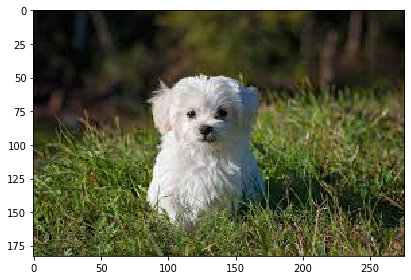

At Epoch  0 -    two dogs are running through the grass  
At Epoch  1 -    black dog is running through the grass  
At Epoch  2 -    black dog is running through the grass  
At Epoch  3 -    two dogs are running through the grass  
At Epoch  4 -    two dogs are running through the grass  
At Epoch  5 -    two dogs are running through the grass  
At Epoch  6 -    two dogs are playing with red ball  
At Epoch  7 -    two dogs are playing in the grass  
At Epoch  8 -    two dogs are playing in the water  
At Epoch  9 -    dog is running through the water  
At Epoch  10 -    black and white dog is running through the grass  
At Epoch  11 -    black and white dog is running through the grass  
At Epoch  12 -    dog is running through the grass  
At Epoch  13 -    dog is running through the grass  
At Epoch  14 -    dog is running through the grass  
At Epoch  15 -    two dogs are playing together on the grass  
At Epoch  16 -    two dogs are playing together in the grass  
At Epoch  17 -   

In [39]:
myimg = io.imread(path_4) 
print("Input Image")
io.imshow(myimg) 
plt.show()
for i in range(0,30):
  # load the model
  model = load_model(f'models_30_1_6000/models_30_1_6000/model_{i}_30_1_6000.h5')
  # load and prepare the photograph
  photo = extract_features('./img4.jpg')
  # generate description
  description = generate_desc(model, tokenizer, photo, max_length)
  description = description.replace("startseq"," ")
  description = description.replace("endseq"," ")
  print("At Epoch ",i,"- ",description)

<center><h1 class="list-group-item list-group-item-success"><font size = 6>🤗THANK YOU🤗</font></h1></center><br>